In [2]:
# Run some setup code for this notebook.
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import ast
from collections import defaultdict
from datetime import datetime, timedelta
from scipy import stats
import pickle

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


In [3]:
# import the price data
prices_df = pd.read_csv(
    '../Data/ds_spx_1990-2020_survivorship_free_prices.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

# import S&P index price
spx_df = pd.read_csv(
    '../Data/ds_spx_1973-2020_index.csv',
    index_col = 0,
    parse_dates = True,
    ).dropna(axis=1, how='all').astype('float32')

# import the mapping table 
map_df = pd.read_csv(
    '../Data/eikon_map_table.csv', 
    index_col = 0
    )

# import the index constituents data
constituents_df = pd.read_csv(
    '../Data/eikon_spx_constituents_1995.csv', 
    index_col = 0, 
    parse_dates = True
    )
constituents_df['Index Constituents'] = constituents_df['Index Constituents'].apply(ast.literal_eval)

In [4]:
# create a monthly date range 
dates = pd.date_range('2010-01', '2020-01', freq = 'BM').strftime('%Y-%m')

# resample price data to weekly intervals starting in 2005
prices_df = prices_df.loc['2010-01-01':, :]
spx_df = spx_df.loc['2010-01-01':, :]
# prices_df = prices_df.resample('W').last()
# spx_df = spx_df.resample('W').last()

# create returns dataframes
returns_df = prices_df.pct_change()
returns_df.iloc[0, :] = 0
spx_returns_df = spx_df.pct_change().fillna(0)

# convert values to NaNs for any time periods where a company is not  a
# constituent of the S&P 500 
for month in dates: 
    constituents = constituents_df.loc[month, 'Index Constituents'].values[0]
    constituents = map_df.loc[constituents, 'ISIN'].values
    not_in_index = [company for company in prices_df[month].columns if company not in constituents]
    prices_df.loc[month, not_in_index] = np.nan
    returns_df.loc[month, not_in_index] = np.nan
    
# for use in the autoencoder, remove any companies that have NaN values
returns_df.dropna(axis = 1, how = 'any', inplace = True)

In [5]:
returns_df.shape

(2752, 326)

In [6]:
# split the data into training and test data
train_start_date = '2010-01-01'
train_end_date = '2014-12-31'
test_start_date = '2015-01-01'
test_end_date = '2019-12-31'

train_prices_df = prices_df[train_start_date:train_end_date]
test_prices_df = prices_df[test_start_date:test_end_date]

train_returns_df = returns_df[train_start_date:train_end_date]
test_returns_df = returns_df[test_start_date:test_end_date]

train_spx_df = spx_df[train_start_date:train_end_date]
test_spx_df = spx_df[test_start_date: test_end_date]

train_spx_returns_df = spx_returns_df[train_start_date: train_end_date]
test_spx_returns_df = spx_returns_df[test_start_date: test_end_date]

In [7]:
# quick check for NaN values
n_nan = 0
for df in [train_returns_df, test_returns_df, train_spx_returns_df, test_spx_returns_df]:
    n_nan += df.isna().sum().values.sum()
    if n_nan > 0: 
        print(n_nan, ' NaN values exist')

In [8]:
def create_model(
    n_nodes_list = (5), 
    reg_type = 'l2',
    penalty = 0.0, 
    batch_size = 252,
    act_funct = 'relu', 
    lr = 0.0001, 
):
    
    model = Sequential()
    n_companies = train_returns_df.shape[1]
    i = 0
    
    if reg_type == 'l1':
        reg_penalty = regularizers.l1(penalty)
    else:
        reg_penalty = regularizers.l2(penalty)
    
    for layer in n_nodes_list:
        if i == 0:
            model.add(Dense(
                layer, 
                activation = act_funct, 
                activity_regularizer = reg_penalty,
                input_shape = (n_companies, )
                     ))
        else:
            model.add(Dense(
                n_nodes_list[layer], 
                activation = act_funct,
                activity_regularizer = reg_penalty
                     ))
        i += 0
    
    opt = Adam(learning_rate = lr)
    model.add(Dense(
        n_companies, 
        activation = 'linear', 
        activity_regularizer = reg_penalty
             ))
    model.compile(optimizer = opt, loss = 'mean_squared_error')
    
    return model

In [9]:
xx = (5,)
for x in xx: 
    print(x)

5


In [10]:
# model = create_model(n_nodes_list = [5, 3, 5])
# early_stopping = EarlyStopping(monitor = 'loss', patience = 5)

# model.fit(
#     train_returns_df, 
#     train_returns_df, 
#     shuffle = False, 
#     validation_split = 0.33, 
# #     validation_data=(test, test),
#     batch_size = 252, 
#     epochs = 500, 
#     callbacks = [early_stopping]
# )

In [11]:
seed = 7
np.random.seed(seed)

In [12]:
model = KerasRegressor(build_fn = create_model, epochs = 500)

In [13]:
n_nodes_list = [(3,), (5,), (5, 3, 5), (10, 5, 3, 5, 10), (10, 10, 10, 10, 10)]
lr = [0.00001, 0.0001, 0.001, 0.01]
batch_size = [5, 21, 63, 126, 252]

print(len(n_nodes_list) * len(lr) * len(batch_size))

param_grid = dict(
    n_nodes_list = n_nodes_list,
    lr = lr,
    batch_size = batch_size
)

param_grid

100


{'n_nodes_list': [(3,),
  (5,),
  (5, 3, 5),
  (10, 5, 3, 5, 10),
  (10, 10, 10, 10, 10)],
 'lr': [1e-05, 0.0001, 0.001, 0.01],
 'batch_size': [5, 21, 63, 126, 252]}

In [14]:
import_grid_search = True

if import_grid_search:
    
    filename = 'model/ae_grid_result_2020_08_18.pkl' # or change the date

    infile = open(filename,'rb')
    grid_result = pickle.load(infile)
    infile.close()
    
else:

    grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = 3)
    grid_result = grid.fit(train_returns_df, train_returns_df)

In [299]:
export_grid_search = False
today = datetime.now().strftime('%Y_%m_%d')

if export_grid_search:
    
    f = open(f'model/ae_grid_result_{today}.pkl', 'wb')
    pickle.dump(grid_result, f)
    f.close()

# grid_result.save('model/ae_grid_result.h5')

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.000132 using {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (5,)}
-0.000149 (0.000020) with: {'batch_size': 5, 'lr': 1e-05, 'n_nodes_list': (3,)}
-0.000147 (0.000020) with: {'batch_size': 5, 'lr': 1e-05, 'n_nodes_list': (5,)}
-0.000149 (0.000020) with: {'batch_size': 5, 'lr': 1e-05, 'n_nodes_list': (5, 3, 5)}
-0.000150 (0.000021) with: {'batch_size': 5, 'lr': 1e-05, 'n_nodes_list': (10, 5, 3, 5, 10)}
-0.000148 (0.000020) with: {'batch_size': 5, 'lr': 1e-05, 'n_nodes_list': (10, 10, 10, 10, 10)}
-0.000140 (0.000018) with: {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (3,)}
-0.000132 (0.000018) with: {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (5,)}
-0.000142 (0.000020) with: {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (5, 3, 5)}
-0.000149 (0.000021) with: {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (10, 5, 3, 5, 10)}
-0.000136 (0.000016) with: {'batch_size': 5, 'lr': 0.0001, 'n_nodes_list': (10, 10, 10, 10, 10)}
-0.000144 (0.000019) with: {'batch_size': 5, 'lr': 

In [16]:
df = pd.DataFrame(zip(means, stds, params), columns = ['mean', 'std', 'params'])
df = df.sort_values('mean', ascending = False)
df.to_csv('../Data/ae_hyper.csv')


### Examine model performance with and without regularisation

In [19]:
import_model_wo_reg = False

if import_model_wo_reg:
    model = load_model('model/ae_model_wo_reg_2020_08_18.h5') # change date as required
    
else:

    model = create_model(**grid_result.best_params_)
    
    model.fit(
    train_returns_df, 
    train_returns_df, 
    shuffle = False, 
    validation_data=(
        test_returns_df, 
        test_returns_df
    ),
    batch_size = 5,
    epochs = 500
)

Train on 1304 samples, validate on 1304 samples
Epoch 1/500
1304/1304 [==============================] - 0s 284us/step - loss: 2.7274e-04 - val_loss: 2.4769e-04
Epoch 2/500
1304/1304 [==============================] - 0s 228us/step - loss: 2.6788e-04 - val_loss: 2.4345e-04
Epoch 3/500
1304/1304 [==============================] - 0s 208us/step - loss: 2.5429e-04 - val_loss: 2.3074e-04
Epoch 4/500
1304/1304 [==============================] - 0s 180us/step - loss: 2.2940e-04 - val_loss: 2.1534e-04
Epoch 5/500
1304/1304 [==============================] - 0s 181us/step - loss: 2.0579e-04 - val_loss: 2.0325e-04
Epoch 6/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.8834e-04 - val_loss: 1.9480e-04
Epoch 7/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.7635e-04 - val_loss: 1.8914e-04
Epoch 8/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.6832e-04 - val_loss: 1.8541e-04
Epoch 9/500
1304/1304 [=========================

1304/1304 [==============================] - 0s 177us/step - loss: 1.3762e-04 - val_loss: 1.6405e-04
Epoch 73/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3748e-04 - val_loss: 1.6387e-04
Epoch 74/500
1304/1304 [==============================] - 0s 256us/step - loss: 1.3734e-04 - val_loss: 1.6368e-04
Epoch 75/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.3720e-04 - val_loss: 1.6349e-04
Epoch 76/500
1304/1304 [==============================] - 0s 226us/step - loss: 1.3706e-04 - val_loss: 1.6329e-04
Epoch 77/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.3691e-04 - val_loss: 1.6309e-04
Epoch 78/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3676e-04 - val_loss: 1.6288e-04
Epoch 79/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.3662e-04 - val_loss: 1.6267e-04
Epoch 80/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3647e-04 - val_loss

1304/1304 [==============================] - 0s 190us/step - loss: 1.3061e-04 - val_loss: 1.5347e-04
Epoch 144/500
1304/1304 [==============================] - 0s 208us/step - loss: 1.3058e-04 - val_loss: 1.5342e-04
Epoch 145/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.3055e-04 - val_loss: 1.5338e-04
Epoch 146/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.3052e-04 - val_loss: 1.5333e-04
Epoch 147/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3049e-04 - val_loss: 1.5329e-04
Epoch 148/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3046e-04 - val_loss: 1.5325e-04
Epoch 149/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3044e-04 - val_loss: 1.5321e-04
Epoch 150/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.3041e-04 - val_loss: 1.5317e-04
Epoch 151/500
1304/1304 [==============================] - 0s 176us/step - loss: 1.3038e-04 - 

1304/1304 [==============================] - 0s 199us/step - loss: 1.2975e-04 - val_loss: 1.5221e-04
Epoch 215/500
1304/1304 [==============================] - 0s 240us/step - loss: 1.2974e-04 - val_loss: 1.5221e-04
Epoch 216/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.2974e-04 - val_loss: 1.5221e-04
Epoch 217/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.2974e-04 - val_loss: 1.5220e-04
Epoch 218/500
1304/1304 [==============================] - 0s 202us/step - loss: 1.2974e-04 - val_loss: 1.5220e-04
Epoch 219/500
1304/1304 [==============================] - 0s 234us/step - loss: 1.2973e-04 - val_loss: 1.5219e-04
Epoch 220/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.2973e-04 - val_loss: 1.5219e-04
Epoch 221/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2973e-04 - val_loss: 1.5219e-04
Epoch 222/500
1304/1304 [==============================] - 0s 214us/step - loss: 1.2973e-04 - 

1304/1304 [==============================] - 0s 178us/step - loss: 1.2965e-04 - val_loss: 1.5207e-04
Epoch 286/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 287/500
1304/1304 [==============================] - 0s 178us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 288/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 289/500
1304/1304 [==============================] - 0s 176us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 290/500
1304/1304 [==============================] - 0s 178us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 291/500
1304/1304 [==============================] - 0s 178us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 292/500
1304/1304 [==============================] - 0s 178us/step - loss: 1.2965e-04 - val_loss: 1.5206e-04
Epoch 293/500
1304/1304 [==============================] - 0s 176us/step - loss: 1.2965e-04 - 

1304/1304 [==============================] - 0s 179us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 357/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 358/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 359/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 360/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 361/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 362/500
1304/1304 [==============================] - 0s 178us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 363/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.2963e-04 - val_loss: 1.5203e-04
Epoch 364/500
1304/1304 [==============================] - 0s 177us/step - loss: 1.2963e-04 - 

1304/1304 [==============================] - 0s 208us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 428/500
1304/1304 [==============================] - 0s 198us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 429/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 430/500
1304/1304 [==============================] - 0s 179us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 431/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 432/500
1304/1304 [==============================] - 0s 228us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 433/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 434/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.2962e-04 - val_loss: 1.5201e-04
Epoch 435/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.2962e-04 - 

1304/1304 [==============================] - 0s 187us/step - loss: 1.2962e-04 - val_loss: 1.5199e-04
Epoch 499/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.2962e-04 - val_loss: 1.5199e-04
Epoch 500/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.2962e-04 - val_loss: 1.5200e-04


In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 1635      
_________________________________________________________________
dense_4 (Dense)              (None, 326)               1956      
Total params: 3,591
Trainable params: 3,591
Non-trainable params: 0
_________________________________________________________________


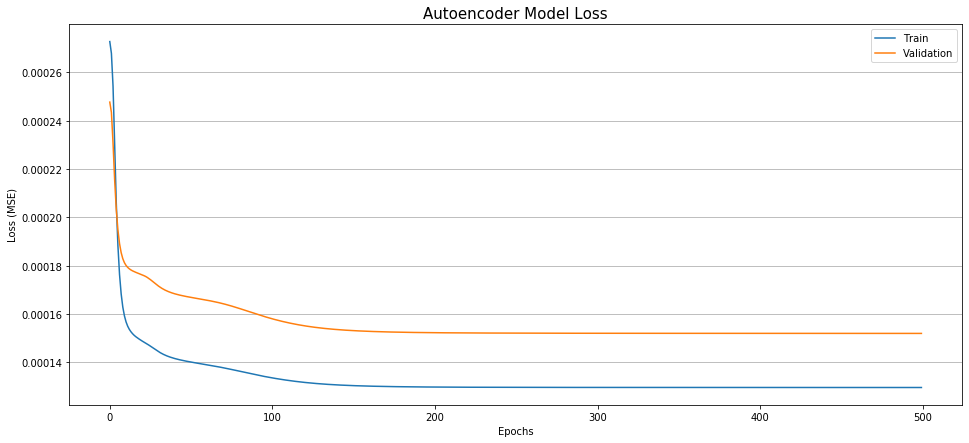

In [22]:
plt.figure(figsize = (16,7))
plt.plot(pd.Series(model.history.history['loss']), label = 'Train')
plt.plot(pd.Series(model.history.history['val_loss']), label = 'Validation')
plt.legend()
plt.title('Autoencoder Model Loss', fontsize = 15)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(axis = 'y')
plt.show()

In [415]:
export_model_wo_reg = True
today = datetime.now().strftime('%Y_%m_%d')

if export_model_wo_reg:
    model.save(f'model/ae_model_wo_reg_{today}.h5')

In [353]:
reconstructed_df = pd.DataFrame(
    model.predict(train_returns_df),
    columns = train_returns_df.columns, 
    index = train_returns_df.index
)

In [354]:
mse_df = pd.DataFrame()

for co in reconstructed_df.columns:
    mse = mean_squared_error(train_returns_df[co], reconstructed_df[co])
    mse_df.loc[co, 'error'] = mse
    
mse_df.sort_values('error', inplace = True)

In [417]:
for isin in mse_df.index:
    name = map_df.loc[map_df['ISIN'] == isin, 'Company Common Name'].values[0]
    mse_df.loc[isin, 'name'] = name

mse_df.to_csv('../Data/ae_top_10.csv')
mse_df.head(10)

,error,name
US98389B1008,0.000028,Xcel Energy Inc
US8425871071,0.000030,Southern Co
US2091151041,0.000031,Consolidated Edison Inc
US5404241086,0.000032,Loews Corp
US2333311072,0.000032,DTE Energy Co
US0530151036,0.000032,Automatic Data Processing Inc
US26441C2044,0.000034,Duke Energy Corp
US4781601046,0.000034,Johnson & Johnson
US92939U1060,0.000035,WEC Energy Group Inc
US7234841010,0.000037,Pinnacle West Capital Corp


In [356]:
reconstructed_df.shape

(1304, 326)

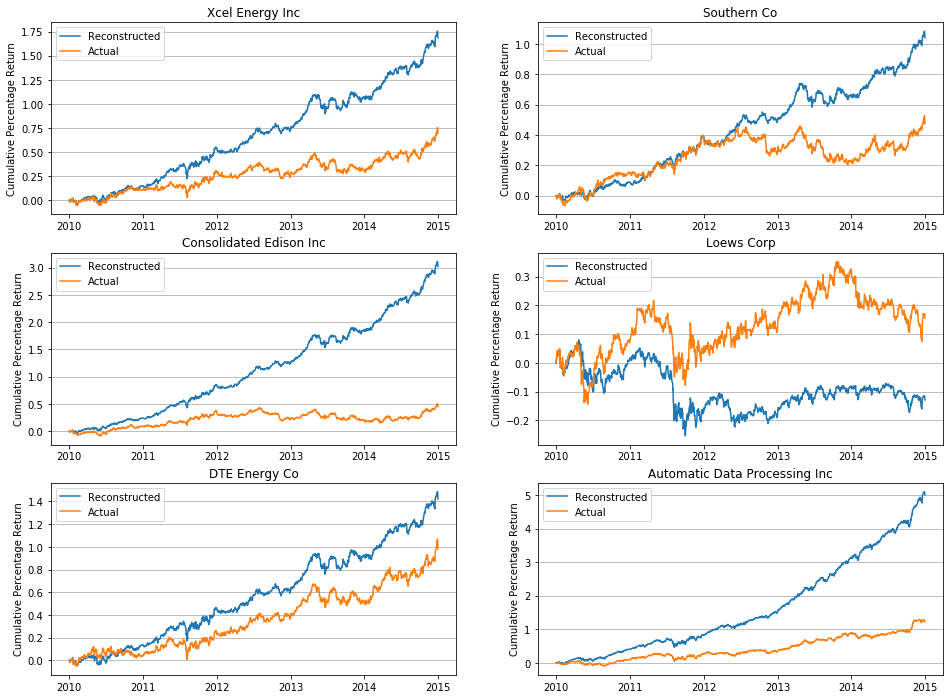

In [408]:
n_top = 6

fig, axs = plt.subplots(nrows = n_top // 2, ncols = 2, figsize=(16, n_top * 2))

for i in range(n_top): 
    isin = mse_df.index[i]
#     isin = mse_df.index[-i+1] # for least representative
    name = mse_df.loc[isin, 'name']
    axs[i//2, i%2].plot(np.cumprod(1 + reconstructed_df[isin]) - 1, label = 'Reconstructed')
    axs[i//2, i%2].plot(np.cumprod(1 + train_returns_df[isin]) - 1, label = 'Actual')
#     axs[i//2, i%2].plot(np.cumsum(np.log(1 + reconstructed_df[isin])), label = 'Reconstructed')
#     axs[i//2, i%2].plot(np.cumsum(np.log(1 + train_returns_df[isin])), label = 'Actual')
    axs[i//2, i%2].legend(loc = 'best')
    axs[i//2, i%2].grid(axis = 'y')
    axs[i//2, i%2].set_title(name)
#     axs[i//2, i%2].set_xlabel('Year')
    axs[i//2, i%2].set_ylabel('Cumulative Percentage Return')
plt.show()


### Examine model performance WITH regularisation

Perform a search to find the regularisation that the model that generalises best

https://towardsdatascience.com/examples-of-bias-variance-tradeoff-in-deep-learning-6420476a20bd

In [313]:
# model_reg = create_model(**grid_result.best_params_, penalty = 0.00002) # with Ridge
# model_reg = create_model(**grid_result.best_params_, penalty = 0.000002) # with LASSO

In [320]:
penalties = [0.00005, 0.000025, 0.00001, 7.5e-6, 5e-6, 2.5e-6, 1e-6, 7.5e-7, 5e-7, 2.5e-7, 1e-7, 7.5e-8, 5e-8, 2.5e-8, 1e-8]
reg_types = ['l1', 'l2']

In [321]:
reg_dict = {}
early_stopping = EarlyStopping(monitor = 'loss', patience = 5)

for x in reg_types:
    for y in penalties: 
        
        # create and fit the model with different regularisations
        model_reg = create_model(**grid_result.best_params_, reg_type = x, penalty = y)
        model_reg.fit(
            train_returns_df, 
            train_returns_df, 
            shuffle = False, 
            validation_data=(
                test_returns_df, 
                test_returns_df
            ),
            batch_size = 5,
            epochs = 500,
            callbacks = [early_stopping]
        )
        
        # determine the difference between the training error and the test error
        score = model_reg.history.history['val_loss'][-1] - model_reg.history.history['loss'][-1]
        
        # create a dictionary object containing the results
        reg_dict[f'{x}_{y}'] = model_reg, score

Train on 1304 samples, validate on 1304 samples
Epoch 1/500
1304/1304 [==============================] - 0s 297us/step - loss: 3.6598e-04 - val_loss: 2.8664e-04
Epoch 2/500
1304/1304 [==============================] - 0s 193us/step - loss: 2.9177e-04 - val_loss: 2.6121e-04
Epoch 3/500
1304/1304 [==============================] - 0s 198us/step - loss: 2.7912e-04 - val_loss: 2.5466e-04
Epoch 4/500
1304/1304 [==============================] - 0s 186us/step - loss: 2.7541e-04 - val_loss: 2.5199e-04
Epoch 5/500
1304/1304 [==============================] - 0s 197us/step - loss: 2.7379e-04 - val_loss: 2.5068e-04
Epoch 6/500
1304/1304 [==============================] - 0s 191us/step - loss: 2.7292e-04 - val_loss: 2.4989e-04
Epoch 7/500
1304/1304 [==============================] - 0s 192us/step - loss: 2.7232e-04 - val_loss: 2.4922e-04
Epoch 8/500
1304/1304 [==============================] - 0s 192us/step - loss: 2.7195e-04 - val_loss: 2.4900e-04
Epoch 9/500
1304/1304 [=========================

Epoch 19/500
1304/1304 [==============================] - 0s 187us/step - loss: 2.5523e-04 - val_loss: 2.3961e-04
Epoch 20/500
1304/1304 [==============================] - 0s 191us/step - loss: 2.5308e-04 - val_loss: 2.3871e-04
Epoch 21/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.5141e-04 - val_loss: 2.3802e-04
Epoch 22/500
1304/1304 [==============================] - 0s 186us/step - loss: 2.5013e-04 - val_loss: 2.3754e-04
Epoch 23/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.4911e-04 - val_loss: 2.3711e-04
Epoch 24/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.4829e-04 - val_loss: 2.3675e-04
Epoch 25/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.4761e-04 - val_loss: 2.3644e-04
Epoch 26/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.4706e-04 - val_loss: 2.3623e-04
Epoch 27/500
1304/1304 [==============================] - 0s 186us/step - loss: 2.4662e-

Epoch 91/500
1304/1304 [==============================] - 0s 227us/step - loss: 2.4479e-04 - val_loss: 2.3523e-04
Epoch 92/500
1304/1304 [==============================] - 0s 213us/step - loss: 2.4478e-04 - val_loss: 2.3525e-04
Epoch 93/500
1304/1304 [==============================] - 0s 183us/step - loss: 2.4478e-04 - val_loss: 2.3527e-04
Epoch 94/500
1304/1304 [==============================] - 0s 207us/step - loss: 2.4478e-04 - val_loss: 2.3523e-04
Epoch 95/500
1304/1304 [==============================] - 0s 187us/step - loss: 2.4477e-04 - val_loss: 2.3524e-04
Epoch 96/500
1304/1304 [==============================] - 0s 183us/step - loss: 2.4477e-04 - val_loss: 2.3524e-04
Epoch 97/500
1304/1304 [==============================] - 0s 195us/step - loss: 2.4477e-04 - val_loss: 2.3524e-04
Epoch 98/500
1304/1304 [==============================] - 0s 218us/step - loss: 2.4476e-04 - val_loss: 2.3525e-04
Epoch 99/500
1304/1304 [==============================] - 0s 206us/step - loss: 2.4475e-

Epoch 4/500
1304/1304 [==============================] - 0s 181us/step - loss: 2.7110e-04 - val_loss: 2.4785e-04
Epoch 5/500
1304/1304 [==============================] - 0s 186us/step - loss: 2.6962e-04 - val_loss: 2.4675e-04
Epoch 6/500
1304/1304 [==============================] - 0s 182us/step - loss: 2.6628e-04 - val_loss: 2.4448e-04
Epoch 7/500
1304/1304 [==============================] - 0s 187us/step - loss: 2.6105e-04 - val_loss: 2.4167e-04
Epoch 8/500
1304/1304 [==============================] - 0s 183us/step - loss: 2.5585e-04 - val_loss: 2.3923e-04
Epoch 9/500
1304/1304 [==============================] - 0s 183us/step - loss: 2.5163e-04 - val_loss: 2.3736e-04
Epoch 10/500
1304/1304 [==============================] - 0s 182us/step - loss: 2.4842e-04 - val_loss: 2.3592e-04
Epoch 11/500
1304/1304 [==============================] - 0s 186us/step - loss: 2.4605e-04 - val_loss: 2.3491e-04
Epoch 12/500
1304/1304 [==============================] - 0s 181us/step - loss: 2.4431e-04 - v

Epoch 76/500
1304/1304 [==============================] - 0s 184us/step - loss: 2.0903e-04 - val_loss: 2.2066e-04
Epoch 77/500
1304/1304 [==============================] - 0s 182us/step - loss: 2.0900e-04 - val_loss: 2.2067e-04
Epoch 78/500
1304/1304 [==============================] - 0s 202us/step - loss: 2.0896e-04 - val_loss: 2.2064e-04
Epoch 79/500
1304/1304 [==============================] - 0s 184us/step - loss: 2.0892e-04 - val_loss: 2.2060e-04
Epoch 80/500
1304/1304 [==============================] - 0s 184us/step - loss: 2.0888e-04 - val_loss: 2.2058e-04
Epoch 81/500
1304/1304 [==============================] - 0s 182us/step - loss: 2.0884e-04 - val_loss: 2.2054e-04
Epoch 82/500
1304/1304 [==============================] - 0s 187us/step - loss: 2.0880e-04 - val_loss: 2.2053e-04
Epoch 83/500
1304/1304 [==============================] - 0s 180us/step - loss: 2.0876e-04 - val_loss: 2.2045e-04
Epoch 84/500
1304/1304 [==============================] - 0s 180us/step - loss: 2.0871e-

1304/1304 [==============================] - 0s 216us/step - loss: 2.0479e-04 - val_loss: 2.1736e-04
Epoch 219/500
1304/1304 [==============================] - 0s 212us/step - loss: 2.0479e-04 - val_loss: 2.1736e-04
Epoch 220/500
1304/1304 [==============================] - 0s 203us/step - loss: 2.0478e-04 - val_loss: 2.1734e-04
Epoch 221/500
1304/1304 [==============================] - 0s 211us/step - loss: 2.0477e-04 - val_loss: 2.1737e-04
Epoch 222/500
1304/1304 [==============================] - 0s 209us/step - loss: 2.0477e-04 - val_loss: 2.1733e-04
Epoch 223/500
1304/1304 [==============================] - 0s 194us/step - loss: 2.0475e-04 - val_loss: 2.1732e-04
Epoch 224/500
1304/1304 [==============================] - 0s 206us/step - loss: 2.0475e-04 - val_loss: 2.1733e-04
Epoch 225/500
1304/1304 [==============================] - 0s 210us/step - loss: 2.0475e-04 - val_loss: 2.1733e-04
Epoch 226/500
1304/1304 [==============================] - 0s 200us/step - loss: 2.0474e-04 - 

1304/1304 [==============================] - 0s 221us/step - loss: 2.0422e-04 - val_loss: 2.1699e-04
Epoch 361/500
1304/1304 [==============================] - 0s 221us/step - loss: 2.0422e-04 - val_loss: 2.1699e-04
Epoch 362/500
1304/1304 [==============================] - 0s 199us/step - loss: 2.0422e-04 - val_loss: 2.1700e-04
Epoch 363/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.0421e-04 - val_loss: 2.1697e-04
Epoch 364/500
1304/1304 [==============================] - 0s 192us/step - loss: 2.0421e-04 - val_loss: 2.1697e-04
Epoch 365/500
1304/1304 [==============================] - 0s 194us/step - loss: 2.0421e-04 - val_loss: 2.1698e-04
Epoch 366/500
1304/1304 [==============================] - 0s 188us/step - loss: 2.0420e-04 - val_loss: 2.1698e-04
Epoch 367/500
1304/1304 [==============================] - 0s 194us/step - loss: 2.0421e-04 - val_loss: 2.1699e-04
Epoch 368/500
1304/1304 [==============================] - 0s 189us/step - loss: 2.0420e-04 - 

Epoch 114/500
1304/1304 [==============================] - 0s 225us/step - loss: 1.9429e-04 - val_loss: 2.0948e-04
Epoch 115/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9421e-04 - val_loss: 2.0940e-04
Epoch 116/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.9415e-04 - val_loss: 2.0932e-04
Epoch 117/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.9409e-04 - val_loss: 2.0924e-04
Epoch 118/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.9401e-04 - val_loss: 2.0917e-04
Epoch 119/500
1304/1304 [==============================] - 0s 206us/step - loss: 1.9395e-04 - val_loss: 2.0910e-04
Epoch 120/500
1304/1304 [==============================] - 0s 219us/step - loss: 1.9388e-04 - val_loss: 2.0904e-04
Epoch 121/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.9383e-04 - val_loss: 2.0897e-04
Epoch 122/500
1304/1304 [==============================] - 0s 282us/step - loss:

1304/1304 [==============================] - 0s 189us/step - loss: 1.9022e-04 - val_loss: 2.0668e-04
Epoch 257/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9024e-04 - val_loss: 2.0667e-04
Epoch 258/500
1304/1304 [==============================] - 0s 192us/step - loss: 1.9019e-04 - val_loss: 2.0663e-04
Epoch 259/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.9019e-04 - val_loss: 2.0662e-04
Epoch 260/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9017e-04 - val_loss: 2.0664e-04
Epoch 261/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9016e-04 - val_loss: 2.0664e-04
Epoch 262/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.9012e-04 - val_loss: 2.0663e-04
Epoch 263/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9013e-04 - val_loss: 2.0662e-04
Epoch 264/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.9009e-04 - 

1304/1304 [==============================] - 0s 215us/step - loss: 1.8782e-04 - val_loss: 2.0481e-04
Epoch 399/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.8781e-04 - val_loss: 2.0478e-04
Epoch 400/500
1304/1304 [==============================] - 0s 256us/step - loss: 1.8780e-04 - val_loss: 2.0479e-04
Epoch 401/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.8778e-04 - val_loss: 2.0476e-04
Epoch 402/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.8777e-04 - val_loss: 2.0477e-04
Epoch 403/500
1304/1304 [==============================] - 0s 229us/step - loss: 1.8776e-04 - val_loss: 2.0475e-04
Epoch 404/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.8775e-04 - val_loss: 2.0474e-04
Epoch 405/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.8772e-04 - val_loss: 2.0473e-04
Epoch 406/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.8771e-04 - 

1304/1304 [==============================] - 0s 204us/step - loss: 1.7286e-04 - val_loss: 1.9586e-04
Epoch 41/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.7280e-04 - val_loss: 1.9579e-04
Epoch 42/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.7273e-04 - val_loss: 1.9570e-04
Epoch 43/500
1304/1304 [==============================] - 0s 198us/step - loss: 1.7266e-04 - val_loss: 1.9562e-04
Epoch 44/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.7259e-04 - val_loss: 1.9552e-04
Epoch 45/500
1304/1304 [==============================] - 0s 192us/step - loss: 1.7252e-04 - val_loss: 1.9543e-04
Epoch 46/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.7244e-04 - val_loss: 1.9532e-04
Epoch 47/500
1304/1304 [==============================] - 0s 200us/step - loss: 1.7236e-04 - val_loss: 1.9522e-04
Epoch 48/500
1304/1304 [==============================] - 0s 209us/step - loss: 1.7228e-04 - val_loss

Epoch 112/500
1304/1304 [==============================] - 0s 203us/step - loss: 1.6724e-04 - val_loss: 1.8882e-04
Epoch 113/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.6720e-04 - val_loss: 1.8877e-04
Epoch 114/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.6715e-04 - val_loss: 1.8870e-04
Epoch 115/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.6710e-04 - val_loss: 1.8861e-04
Epoch 116/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.6704e-04 - val_loss: 1.8854e-04
Epoch 117/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.6699e-04 - val_loss: 1.8846e-04
Epoch 118/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.6693e-04 - val_loss: 1.8837e-04
Epoch 119/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.6688e-04 - val_loss: 1.8829e-04
Epoch 120/500
1304/1304 [==============================] - 0s 194us/step - loss:

1304/1304 [==============================] - 0s 193us/step - loss: 1.6318e-04 - val_loss: 1.8303e-04
Epoch 255/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.6317e-04 - val_loss: 1.8302e-04
Epoch 256/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.6317e-04 - val_loss: 1.8302e-04
Epoch 257/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.6316e-04 - val_loss: 1.8302e-04
Epoch 258/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.6316e-04 - val_loss: 1.8301e-04
Epoch 259/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.6316e-04 - val_loss: 1.8301e-04
Epoch 260/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.6315e-04 - val_loss: 1.8301e-04
Epoch 261/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.6315e-04 - val_loss: 1.8300e-04
Epoch 262/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.6314e-04 - 

1304/1304 [==============================] - 0s 196us/step - loss: 1.6275e-04 - val_loss: 1.8272e-04
Epoch 397/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.6275e-04 - val_loss: 1.8272e-04
Epoch 398/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.6274e-04 - val_loss: 1.8272e-04
Epoch 399/500
1304/1304 [==============================] - 0s 232us/step - loss: 1.6274e-04 - val_loss: 1.8272e-04
Epoch 400/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.6274e-04 - val_loss: 1.8271e-04
Epoch 401/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.6274e-04 - val_loss: 1.8271e-04
Epoch 402/500
1304/1304 [==============================] - 0s 202us/step - loss: 1.6274e-04 - val_loss: 1.8271e-04
Epoch 403/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.6273e-04 - val_loss: 1.8271e-04
Epoch 404/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.6273e-04 - 

1304/1304 [==============================] - 0s 187us/step - loss: 1.5745e-04 - val_loss: 1.8447e-04
Epoch 39/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.5737e-04 - val_loss: 1.8436e-04
Epoch 40/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.5730e-04 - val_loss: 1.8425e-04
Epoch 41/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.5722e-04 - val_loss: 1.8413e-04
Epoch 42/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.5714e-04 - val_loss: 1.8401e-04
Epoch 43/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.5706e-04 - val_loss: 1.8389e-04
Epoch 44/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.5698e-04 - val_loss: 1.8376e-04
Epoch 45/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.5690e-04 - val_loss: 1.8362e-04
Epoch 46/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.5681e-04 - val_loss

Epoch 110/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.5001e-04 - val_loss: 1.7239e-04
Epoch 111/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.4998e-04 - val_loss: 1.7235e-04
Epoch 112/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4995e-04 - val_loss: 1.7233e-04
Epoch 113/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.4992e-04 - val_loss: 1.7230e-04
Epoch 114/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4989e-04 - val_loss: 1.7228e-04
Epoch 115/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4986e-04 - val_loss: 1.7225e-04
Epoch 116/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4983e-04 - val_loss: 1.7223e-04
Epoch 117/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.4980e-04 - val_loss: 1.7222e-04
Epoch 118/500
1304/1304 [==============================] - 0s 182us/step - loss:

1304/1304 [==============================] - 0s 182us/step - loss: 1.4636e-04 - val_loss: 1.6972e-04
Epoch 253/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4633e-04 - val_loss: 1.6968e-04
Epoch 254/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4629e-04 - val_loss: 1.6964e-04
Epoch 255/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4625e-04 - val_loss: 1.6960e-04
Epoch 256/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.4621e-04 - val_loss: 1.6956e-04
Epoch 257/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.4617e-04 - val_loss: 1.6951e-04
Epoch 258/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4612e-04 - val_loss: 1.6947e-04
Epoch 259/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4608e-04 - val_loss: 1.6942e-04
Epoch 260/500
1304/1304 [==============================] - 0s 180us/step - loss: 1.4604e-04 - 

1304/1304 [==============================] - 0s 183us/step - loss: 1.4381e-04 - val_loss: 1.6568e-04
Epoch 395/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4380e-04 - val_loss: 1.6566e-04
Epoch 396/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4379e-04 - val_loss: 1.6565e-04
Epoch 397/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.4379e-04 - val_loss: 1.6563e-04
Epoch 398/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.4378e-04 - val_loss: 1.6561e-04
Epoch 399/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4377e-04 - val_loss: 1.6560e-04
Epoch 400/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.4377e-04 - val_loss: 1.6558e-04
Epoch 401/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.4376e-04 - val_loss: 1.6557e-04
Epoch 402/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4375e-04 - 

1304/1304 [==============================] - 0s 186us/step - loss: 1.5315e-04 - val_loss: 1.7950e-04
Epoch 37/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.5297e-04 - val_loss: 1.7923e-04
Epoch 38/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.5279e-04 - val_loss: 1.7896e-04
Epoch 39/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.5261e-04 - val_loss: 1.7869e-04
Epoch 40/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.5243e-04 - val_loss: 1.7842e-04
Epoch 41/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.5225e-04 - val_loss: 1.7815e-04
Epoch 42/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.5207e-04 - val_loss: 1.7789e-04
Epoch 43/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.5190e-04 - val_loss: 1.7762e-04
Epoch 44/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.5173e-04 - val_loss

Epoch 108/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4571e-04 - val_loss: 1.6954e-04
Epoch 109/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4569e-04 - val_loss: 1.6952e-04
Epoch 110/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4567e-04 - val_loss: 1.6950e-04
Epoch 111/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4565e-04 - val_loss: 1.6948e-04
Epoch 112/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4563e-04 - val_loss: 1.6946e-04
Epoch 113/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4561e-04 - val_loss: 1.6945e-04
Epoch 114/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4559e-04 - val_loss: 1.6943e-04
Epoch 115/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.4557e-04 - val_loss: 1.6942e-04
Epoch 116/500
1304/1304 [==============================] - 0s 186us/step - loss:

1304/1304 [==============================] - 0s 185us/step - loss: 1.4408e-04 - val_loss: 1.6829e-04
Epoch 251/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4405e-04 - val_loss: 1.6825e-04
Epoch 252/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4403e-04 - val_loss: 1.6822e-04
Epoch 253/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4401e-04 - val_loss: 1.6817e-04
Epoch 254/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4398e-04 - val_loss: 1.6813e-04
Epoch 255/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4396e-04 - val_loss: 1.6808e-04
Epoch 256/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4393e-04 - val_loss: 1.6802e-04
Epoch 257/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4390e-04 - val_loss: 1.6795e-04
Epoch 258/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4387e-04 - 

1304/1304 [==============================] - 0s 186us/step - loss: 1.4041e-04 - val_loss: 1.6245e-04
Epoch 393/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4040e-04 - val_loss: 1.6245e-04
Epoch 394/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4040e-04 - val_loss: 1.6244e-04
Epoch 395/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4040e-04 - val_loss: 1.6244e-04
Epoch 396/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4040e-04 - val_loss: 1.6243e-04
Epoch 397/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4039e-04 - val_loss: 1.6243e-04
Epoch 398/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4039e-04 - val_loss: 1.6243e-04
Epoch 399/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.4039e-04 - val_loss: 1.6242e-04
Epoch 400/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4038e-04 - 

1304/1304 [==============================] - 0s 246us/step - loss: 1.5159e-04 - val_loss: 1.7983e-04
Epoch 35/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.5152e-04 - val_loss: 1.7974e-04
Epoch 36/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.5144e-04 - val_loss: 1.7965e-04
Epoch 37/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.5136e-04 - val_loss: 1.7955e-04
Epoch 38/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.5129e-04 - val_loss: 1.7946e-04
Epoch 39/500
1304/1304 [==============================] - 0s 200us/step - loss: 1.5121e-04 - val_loss: 1.7937e-04
Epoch 40/500
1304/1304 [==============================] - 0s 213us/step - loss: 1.5114e-04 - val_loss: 1.7928e-04
Epoch 41/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.5106e-04 - val_loss: 1.7918e-04
Epoch 42/500
1304/1304 [==============================] - 0s 197us/step - loss: 1.5098e-04 - val_loss

Epoch 106/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.4211e-04 - val_loss: 1.6756e-04
Epoch 107/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4202e-04 - val_loss: 1.6745e-04
Epoch 108/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.4193e-04 - val_loss: 1.6735e-04
Epoch 109/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4184e-04 - val_loss: 1.6725e-04
Epoch 110/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4176e-04 - val_loss: 1.6715e-04
Epoch 111/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.4167e-04 - val_loss: 1.6705e-04
Epoch 112/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.4159e-04 - val_loss: 1.6695e-04
Epoch 113/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4151e-04 - val_loss: 1.6686e-04
Epoch 114/500
1304/1304 [==============================] - 0s 183us/step - loss:

1304/1304 [==============================] - 0s 185us/step - loss: 1.3754e-04 - val_loss: 1.6205e-04
Epoch 249/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3753e-04 - val_loss: 1.6204e-04
Epoch 250/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.3753e-04 - val_loss: 1.6203e-04
Epoch 251/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.3753e-04 - val_loss: 1.6202e-04
Epoch 252/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.3752e-04 - val_loss: 1.6201e-04
Epoch 253/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.3752e-04 - val_loss: 1.6200e-04
Epoch 254/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.3751e-04 - val_loss: 1.6199e-04
Epoch 255/500
1304/1304 [==============================] - 0s 181us/step - loss: 1.3751e-04 - val_loss: 1.6198e-04
Epoch 256/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.3750e-04 - 

1304/1304 [==============================] - 0s 187us/step - loss: 1.3693e-04 - val_loss: 1.6001e-04
Epoch 391/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.3693e-04 - val_loss: 1.5999e-04
Epoch 392/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.3693e-04 - val_loss: 1.5998e-04
Epoch 393/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.3692e-04 - val_loss: 1.5997e-04
Epoch 394/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.3692e-04 - val_loss: 1.5995e-04
Epoch 395/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3692e-04 - val_loss: 1.5994e-04
Epoch 396/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.3691e-04 - val_loss: 1.5993e-04
Epoch 397/500
1304/1304 [==============================] - 0s 182us/step - loss: 1.3691e-04 - val_loss: 1.5992e-04
Epoch 398/500
1304/1304 [==============================] - 0s 183us/step - loss: 1.3691e-04 - 

1304/1304 [==============================] - 0s 186us/step - loss: 1.4841e-04 - val_loss: 1.7602e-04
Epoch 33/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4817e-04 - val_loss: 1.7577e-04
Epoch 34/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.4794e-04 - val_loss: 1.7552e-04
Epoch 35/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4772e-04 - val_loss: 1.7526e-04
Epoch 36/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4751e-04 - val_loss: 1.7500e-04
Epoch 37/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4730e-04 - val_loss: 1.7474e-04
Epoch 38/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4709e-04 - val_loss: 1.7447e-04
Epoch 39/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.4689e-04 - val_loss: 1.7419e-04
Epoch 40/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4668e-04 - val_loss

Epoch 104/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.3567e-04 - val_loss: 1.5802e-04
Epoch 105/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.3560e-04 - val_loss: 1.5792e-04
Epoch 106/500
1304/1304 [==============================] - 0s 198us/step - loss: 1.3553e-04 - val_loss: 1.5783e-04
Epoch 107/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.3547e-04 - val_loss: 1.5774e-04
Epoch 108/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.3541e-04 - val_loss: 1.5766e-04
Epoch 109/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.3535e-04 - val_loss: 1.5758e-04
Epoch 110/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.3530e-04 - val_loss: 1.5750e-04
Epoch 111/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.3524e-04 - val_loss: 1.5743e-04
Epoch 112/500
1304/1304 [==============================] - 0s 219us/step - loss:

1304/1304 [==============================] - 0s 193us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 247/500
1304/1304 [==============================] - 0s 192us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 248/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 249/500
1304/1304 [==============================] - 0s 200us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 250/500
1304/1304 [==============================] - 0s 203us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 251/500
1304/1304 [==============================] - 0s 197us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 252/500
1304/1304 [==============================] - 0s 217us/step - loss: 1.3386e-04 - val_loss: 1.5594e-04
Epoch 253/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.3385e-04 - val_loss: 1.5594e-04
Epoch 254/500
1304/1304 [==============================] - 0s 211us/step - loss: 1.3385e-04 - 

1304/1304 [==============================] - 0s 187us/step - loss: 1.3372e-04 - val_loss: 1.5583e-04
Epoch 389/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.3372e-04 - val_loss: 1.5583e-04
Epoch 390/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3372e-04 - val_loss: 1.5583e-04
Epoch 391/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.3372e-04 - val_loss: 1.5583e-04
Epoch 392/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3372e-04 - val_loss: 1.5582e-04
Epoch 393/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.3371e-04 - val_loss: 1.5582e-04
Epoch 394/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3371e-04 - val_loss: 1.5582e-04
Epoch 395/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.3371e-04 - val_loss: 1.5582e-04
Epoch 396/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.3371e-04 - 

1304/1304 [==============================] - 0s 220us/step - loss: 1.4711e-04 - val_loss: 1.7386e-04
Epoch 31/500
1304/1304 [==============================] - 0s 228us/step - loss: 1.4678e-04 - val_loss: 1.7338e-04
Epoch 32/500
1304/1304 [==============================] - 0s 201us/step - loss: 1.4642e-04 - val_loss: 1.7283e-04
Epoch 33/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.4600e-04 - val_loss: 1.7218e-04
Epoch 34/500
1304/1304 [==============================] - 0s 213us/step - loss: 1.4555e-04 - val_loss: 1.7150e-04
Epoch 35/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.4506e-04 - val_loss: 1.7080e-04
Epoch 36/500
1304/1304 [==============================] - 0s 201us/step - loss: 1.4457e-04 - val_loss: 1.7012e-04
Epoch 37/500
1304/1304 [==============================] - 0s 192us/step - loss: 1.4408e-04 - val_loss: 1.6947e-04
Epoch 38/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.4361e-04 - val_loss

Epoch 102/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.3087e-04 - val_loss: 1.5318e-04
Epoch 103/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3081e-04 - val_loss: 1.5312e-04
Epoch 104/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.3075e-04 - val_loss: 1.5307e-04
Epoch 105/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.3070e-04 - val_loss: 1.5302e-04
Epoch 106/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.3064e-04 - val_loss: 1.5297e-04
Epoch 107/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.3059e-04 - val_loss: 1.5292e-04
Epoch 108/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.3053e-04 - val_loss: 1.5287e-04
Epoch 109/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.3048e-04 - val_loss: 1.5282e-04
Epoch 110/500
1304/1304 [==============================] - 0s 185us/step - loss:

1304/1304 [==============================] - 0s 188us/step - loss: 1.2789e-04 - val_loss: 1.5066e-04
Epoch 245/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.2789e-04 - val_loss: 1.5066e-04
Epoch 246/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.2788e-04 - val_loss: 1.5066e-04
Epoch 247/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.2788e-04 - val_loss: 1.5065e-04
Epoch 248/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.2788e-04 - val_loss: 1.5065e-04
Epoch 249/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.2787e-04 - val_loss: 1.5064e-04
Epoch 250/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.2787e-04 - val_loss: 1.5064e-04
Epoch 251/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.2787e-04 - val_loss: 1.5063e-04
Epoch 252/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.2786e-04 - 

1304/1304 [==============================] - 0s 198us/step - loss: 1.2767e-04 - val_loss: 1.5030e-04
Epoch 387/500
1304/1304 [==============================] - 0s 242us/step - loss: 1.2767e-04 - val_loss: 1.5030e-04
Epoch 388/500
1304/1304 [==============================] - 0s 233us/step - loss: 1.2767e-04 - val_loss: 1.5030e-04
Epoch 389/500
1304/1304 [==============================] - 0s 220us/step - loss: 1.2767e-04 - val_loss: 1.5029e-04
Epoch 390/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.2767e-04 - val_loss: 1.5029e-04
Epoch 391/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.2767e-04 - val_loss: 1.5029e-04
Epoch 392/500
1304/1304 [==============================] - 0s 212us/step - loss: 1.2767e-04 - val_loss: 1.5029e-04
Epoch 393/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.2767e-04 - val_loss: 1.5029e-04
Epoch 394/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.2767e-04 - 

1304/1304 [==============================] - 0s 186us/step - loss: 1.4696e-04 - val_loss: 1.7283e-04
Epoch 29/500
1304/1304 [==============================] - 0s 193us/step - loss: 1.4657e-04 - val_loss: 1.7244e-04
Epoch 30/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4619e-04 - val_loss: 1.7204e-04
Epoch 31/500
1304/1304 [==============================] - 0s 184us/step - loss: 1.4582e-04 - val_loss: 1.7164e-04
Epoch 32/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4545e-04 - val_loss: 1.7124e-04
Epoch 33/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.4510e-04 - val_loss: 1.7084e-04
Epoch 34/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4475e-04 - val_loss: 1.7045e-04
Epoch 35/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.4441e-04 - val_loss: 1.7005e-04
Epoch 36/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.4408e-04 - val_loss

Epoch 100/500
1304/1304 [==============================] - 0s 241us/step - loss: 1.3123e-04 - val_loss: 1.5328e-04
Epoch 101/500
1304/1304 [==============================] - 0s 266us/step - loss: 1.3115e-04 - val_loss: 1.5318e-04
Epoch 102/500
1304/1304 [==============================] - 0s 298us/step - loss: 1.3108e-04 - val_loss: 1.5307e-04
Epoch 103/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.3101e-04 - val_loss: 1.5297e-04
Epoch 104/500
1304/1304 [==============================] - 0s 272us/step - loss: 1.3094e-04 - val_loss: 1.5287e-04
Epoch 105/500
1304/1304 [==============================] - 0s 215us/step - loss: 1.3087e-04 - val_loss: 1.5277e-04
Epoch 106/500
1304/1304 [==============================] - 0s 197us/step - loss: 1.3080e-04 - val_loss: 1.5268e-04
Epoch 107/500
1304/1304 [==============================] - 0s 221us/step - loss: 1.3073e-04 - val_loss: 1.5258e-04
Epoch 108/500
1304/1304 [==============================] - 0s 189us/step - loss:

1304/1304 [==============================] - 0s 187us/step - loss: 1.2754e-04 - val_loss: 1.4892e-04
Epoch 243/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.2753e-04 - val_loss: 1.4892e-04
Epoch 244/500
1304/1304 [==============================] - 0s 191us/step - loss: 1.2753e-04 - val_loss: 1.4892e-04
Epoch 245/500
1304/1304 [==============================] - 0s 185us/step - loss: 1.2752e-04 - val_loss: 1.4892e-04
Epoch 246/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.2752e-04 - val_loss: 1.4892e-04
Epoch 247/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.2751e-04 - val_loss: 1.4892e-04
Epoch 248/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.2751e-04 - val_loss: 1.4892e-04
Epoch 249/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.2750e-04 - val_loss: 1.4892e-04
Epoch 250/500
1304/1304 [==============================] - 0s 188us/step - loss: 1.2750e-04 - 

1304/1304 [==============================] - 0s 187us/step - loss: 1.2725e-04 - val_loss: 1.4913e-04
Epoch 385/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.2725e-04 - val_loss: 1.4913e-04
Epoch 386/500
1304/1304 [==============================] - 0s 197us/step - loss: 1.2725e-04 - val_loss: 1.4913e-04
Epoch 387/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.2725e-04 - val_loss: 1.4913e-04
Epoch 388/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.2725e-04 - val_loss: 1.4913e-04
Epoch 389/500
1304/1304 [==============================] - 0s 186us/step - loss: 1.2725e-04 - val_loss: 1.4914e-04
Epoch 390/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.2725e-04 - val_loss: 1.4914e-04
Epoch 391/500
1304/1304 [==============================] - 0s 190us/step - loss: 1.2725e-04 - val_loss: 1.4914e-04
Epoch 392/500
1304/1304 [==============================] - 0s 189us/step - loss: 1.2724e-04 - 

1304/1304 [==============================] - 0s 297us/step - loss: 1.4772e-04 - val_loss: 1.7589e-04
Epoch 27/500
1304/1304 [==============================] - 0s 328us/step - loss: 1.4740e-04 - val_loss: 1.7561e-04
Epoch 28/500
1304/1304 [==============================] - 0s 283us/step - loss: 1.4708e-04 - val_loss: 1.7534e-04
Epoch 29/500
1304/1304 [==============================] - 0s 311us/step - loss: 1.4676e-04 - val_loss: 1.7505e-04
Epoch 30/500
1304/1304 [==============================] - 0s 278us/step - loss: 1.4646e-04 - val_loss: 1.7476e-04
Epoch 31/500
1304/1304 [==============================] - 0s 275us/step - loss: 1.4615e-04 - val_loss: 1.7446e-04
Epoch 32/500
1304/1304 [==============================] - 0s 269us/step - loss: 1.4584e-04 - val_loss: 1.7415e-04
Epoch 33/500
1304/1304 [==============================] - 0s 252us/step - loss: 1.4553e-04 - val_loss: 1.7383e-04
Epoch 34/500
1304/1304 [==============================] - 0s 255us/step - loss: 1.4522e-04 - val_loss

Epoch 98/500
1304/1304 [==============================] - 0s 229us/step - loss: 1.3446e-04 - val_loss: 1.5960e-04
Epoch 99/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.3440e-04 - val_loss: 1.5952e-04
Epoch 100/500
1304/1304 [==============================] - 0s 227us/step - loss: 1.3434e-04 - val_loss: 1.5943e-04
Epoch 101/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.3429e-04 - val_loss: 1.5934e-04
Epoch 102/500
1304/1304 [==============================] - 0s 232us/step - loss: 1.3423e-04 - val_loss: 1.5925e-04
Epoch 103/500
1304/1304 [==============================] - 0s 237us/step - loss: 1.3417e-04 - val_loss: 1.5917e-04
Epoch 104/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.3411e-04 - val_loss: 1.5908e-04
Epoch 105/500
1304/1304 [==============================] - 0s 235us/step - loss: 1.3405e-04 - val_loss: 1.5899e-04
Epoch 106/500
1304/1304 [==============================] - 0s 237us/step - loss: 1

1304/1304 [==============================] - 0s 359us/step - loss: 1.3071e-04 - val_loss: 1.5346e-04
Epoch 241/500
1304/1304 [==============================] - 0s 322us/step - loss: 1.3070e-04 - val_loss: 1.5346e-04
Epoch 242/500
1304/1304 [==============================] - 0s 334us/step - loss: 1.3070e-04 - val_loss: 1.5345e-04
Epoch 243/500
1304/1304 [==============================] - 0s 287us/step - loss: 1.3070e-04 - val_loss: 1.5345e-04
Epoch 244/500
1304/1304 [==============================] - 0s 319us/step - loss: 1.3069e-04 - val_loss: 1.5344e-04
Epoch 245/500
1304/1304 [==============================] - 0s 319us/step - loss: 1.3069e-04 - val_loss: 1.5343e-04
Epoch 246/500
1304/1304 [==============================] - 0s 323us/step - loss: 1.3069e-04 - val_loss: 1.5343e-04
Epoch 247/500
1304/1304 [==============================] - 0s 366us/step - loss: 1.3069e-04 - val_loss: 1.5342e-04
Epoch 248/500
1304/1304 [==============================] - 0s 334us/step - loss: 1.3068e-04 - 

1304/1304 [==============================] - 1s 395us/step - loss: 1.3054e-04 - val_loss: 1.5305e-04
Epoch 383/500
1304/1304 [==============================] - 1s 390us/step - loss: 1.3054e-04 - val_loss: 1.5305e-04
Epoch 384/500
1304/1304 [==============================] - 0s 382us/step - loss: 1.3054e-04 - val_loss: 1.5305e-04
Epoch 385/500
1304/1304 [==============================] - 0s 361us/step - loss: 1.3054e-04 - val_loss: 1.5304e-04
Epoch 386/500
1304/1304 [==============================] - 1s 525us/step - loss: 1.3053e-04 - val_loss: 1.5304e-04
Epoch 387/500
1304/1304 [==============================] - 1s 394us/step - loss: 1.3053e-04 - val_loss: 1.5304e-04
Epoch 388/500
1304/1304 [==============================] - 0s 381us/step - loss: 1.3053e-04 - val_loss: 1.5304e-04
Epoch 389/500
1304/1304 [==============================] - 0s 381us/step - loss: 1.3053e-04 - val_loss: 1.5304e-04
Epoch 390/500
1304/1304 [==============================] - 1s 388us/step - loss: 1.3053e-04 - 

1304/1304 [==============================] - 1s 413us/step - loss: 1.4785e-04 - val_loss: 1.7604e-04
Epoch 25/500
1304/1304 [==============================] - 1s 389us/step - loss: 1.4749e-04 - val_loss: 1.7574e-04
Epoch 26/500
1304/1304 [==============================] - 1s 447us/step - loss: 1.4713e-04 - val_loss: 1.7539e-04
Epoch 27/500
1304/1304 [==============================] - 1s 388us/step - loss: 1.4675e-04 - val_loss: 1.7501e-04
Epoch 28/500
1304/1304 [==============================] - 1s 444us/step - loss: 1.4636e-04 - val_loss: 1.7458e-04
Epoch 29/500
1304/1304 [==============================] - 0s 383us/step - loss: 1.4594e-04 - val_loss: 1.7409e-04
Epoch 30/500
1304/1304 [==============================] - 1s 409us/step - loss: 1.4549e-04 - val_loss: 1.7355e-04
Epoch 31/500
1304/1304 [==============================] - 1s 490us/step - loss: 1.4500e-04 - val_loss: 1.7296e-04
Epoch 32/500
1304/1304 [==============================] - 0s 381us/step - loss: 1.4448e-04 - val_loss

Epoch 96/500
1304/1304 [==============================] - 0s 269us/step - loss: 1.3220e-04 - val_loss: 1.5607e-04
Epoch 97/500
1304/1304 [==============================] - 0s 274us/step - loss: 1.3211e-04 - val_loss: 1.5591e-04
Epoch 98/500
1304/1304 [==============================] - 0s 269us/step - loss: 1.3201e-04 - val_loss: 1.5575e-04
Epoch 99/500
1304/1304 [==============================] - 0s 301us/step - loss: 1.3191e-04 - val_loss: 1.5559e-04
Epoch 100/500
1304/1304 [==============================] - 0s 293us/step - loss: 1.3182e-04 - val_loss: 1.5543e-04
Epoch 101/500
1304/1304 [==============================] - 0s 278us/step - loss: 1.3172e-04 - val_loss: 1.5527e-04
Epoch 102/500
1304/1304 [==============================] - 0s 281us/step - loss: 1.3162e-04 - val_loss: 1.5512e-04
Epoch 103/500
1304/1304 [==============================] - 0s 269us/step - loss: 1.3153e-04 - val_loss: 1.5496e-04
Epoch 104/500
1304/1304 [==============================] - 0s 267us/step - loss: 1.3

1304/1304 [==============================] - 0s 267us/step - loss: 1.2663e-04 - val_loss: 1.4818e-04
Epoch 239/500
1304/1304 [==============================] - 0s 262us/step - loss: 1.2662e-04 - val_loss: 1.4818e-04
Epoch 240/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.2661e-04 - val_loss: 1.4818e-04
Epoch 241/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.2661e-04 - val_loss: 1.4818e-04
Epoch 242/500
1304/1304 [==============================] - 0s 294us/step - loss: 1.2661e-04 - val_loss: 1.4818e-04
Epoch 243/500
1304/1304 [==============================] - 0s 280us/step - loss: 1.2660e-04 - val_loss: 1.4817e-04
Epoch 244/500
1304/1304 [==============================] - 0s 292us/step - loss: 1.2660e-04 - val_loss: 1.4817e-04
Epoch 245/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.2659e-04 - val_loss: 1.4817e-04
Epoch 246/500
1304/1304 [==============================] - 0s 286us/step - loss: 1.2659e-04 - 

1304/1304 [==============================] - 1s 594us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 381/500
1304/1304 [==============================] - 1s 560us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 382/500
1304/1304 [==============================] - 1s 548us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 383/500
1304/1304 [==============================] - 1s 508us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 384/500
1304/1304 [==============================] - 1s 511us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 385/500
1304/1304 [==============================] - 1s 520us/step - loss: 1.2637e-04 - val_loss: 1.4831e-04
Epoch 386/500
1304/1304 [==============================] - 1s 555us/step - loss: 1.2637e-04 - val_loss: 1.4832e-04
Epoch 387/500
1304/1304 [==============================] - 1s 602us/step - loss: 1.2637e-04 - val_loss: 1.4832e-04
Epoch 388/500
1304/1304 [==============================] - 1s 598us/step - loss: 1.2637e-04 - 

1304/1304 [==============================] - 1s 515us/step - loss: 1.4949e-04 - val_loss: 1.7720e-04
Epoch 23/500
1304/1304 [==============================] - 1s 480us/step - loss: 1.4913e-04 - val_loss: 1.7700e-04
Epoch 24/500
1304/1304 [==============================] - 1s 514us/step - loss: 1.4876e-04 - val_loss: 1.7680e-04
Epoch 25/500
1304/1304 [==============================] - 1s 536us/step - loss: 1.4839e-04 - val_loss: 1.7662e-04
Epoch 26/500
1304/1304 [==============================] - 1s 589us/step - loss: 1.4804e-04 - val_loss: 1.7643e-04
Epoch 27/500
1304/1304 [==============================] - 1s 538us/step - loss: 1.4770e-04 - val_loss: 1.7625e-04
Epoch 28/500
1304/1304 [==============================] - 1s 525us/step - loss: 1.4739e-04 - val_loss: 1.7608e-04
Epoch 29/500
1304/1304 [==============================] - 1s 548us/step - loss: 1.4711e-04 - val_loss: 1.7593e-04
Epoch 30/500
1304/1304 [==============================] - 1s 506us/step - loss: 1.4688e-04 - val_loss

Epoch 94/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.3657e-04 - val_loss: 1.6091e-04
Epoch 95/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.3637e-04 - val_loss: 1.6062e-04
Epoch 96/500
1304/1304 [==============================] - 0s 204us/step - loss: 1.3617e-04 - val_loss: 1.6033e-04
Epoch 97/500
1304/1304 [==============================] - 0s 203us/step - loss: 1.3597e-04 - val_loss: 1.6004e-04
Epoch 98/500
1304/1304 [==============================] - 0s 226us/step - loss: 1.3577e-04 - val_loss: 1.5974e-04
Epoch 99/500
1304/1304 [==============================] - 0s 217us/step - loss: 1.3555e-04 - val_loss: 1.5945e-04
Epoch 100/500
1304/1304 [==============================] - 0s 212us/step - loss: 1.3534e-04 - val_loss: 1.5915e-04
Epoch 101/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.3513e-04 - val_loss: 1.5886e-04
Epoch 102/500
1304/1304 [==============================] - 0s 209us/step - loss: 1.349

1304/1304 [==============================] - 1s 878us/step - loss: 1.2984e-04 - val_loss: 1.5214e-04
Epoch 237/500
1304/1304 [==============================] - 1s 659us/step - loss: 1.2984e-04 - val_loss: 1.5214e-04
Epoch 238/500
1304/1304 [==============================] - 1s 915us/step - loss: 1.2984e-04 - val_loss: 1.5214e-04
Epoch 239/500
1304/1304 [==============================] - 1s 845us/step - loss: 1.2983e-04 - val_loss: 1.5214e-04
Epoch 240/500
1304/1304 [==============================] - 1s 632us/step - loss: 1.2983e-04 - val_loss: 1.5213e-04
Epoch 241/500
1304/1304 [==============================] - 1s 713us/step - loss: 1.2983e-04 - val_loss: 1.5213e-04
Epoch 242/500
1304/1304 [==============================] - 1s 533us/step - loss: 1.2983e-04 - val_loss: 1.5213e-04
Epoch 243/500
1304/1304 [==============================] - 1s 702us/step - loss: 1.2983e-04 - val_loss: 1.5213e-04
Epoch 244/500
1304/1304 [==============================] - 1s 744us/step - loss: 1.2983e-04 - 

1304/1304 [==============================] - 1s 874us/step - loss: 1.2972e-04 - val_loss: 1.5205e-04
Epoch 379/500
1304/1304 [==============================] - 1s 772us/step - loss: 1.2972e-04 - val_loss: 1.5205e-04
Epoch 380/500
1304/1304 [==============================] - 1s 630us/step - loss: 1.2972e-04 - val_loss: 1.5205e-04
Epoch 381/500
1304/1304 [==============================] - 1s 782us/step - loss: 1.2972e-04 - val_loss: 1.5205e-04
Epoch 382/500
1304/1304 [==============================] - 1s 659us/step - loss: 1.2971e-04 - val_loss: 1.5205e-04
Epoch 383/500
1304/1304 [==============================] - 1s 789us/step - loss: 1.2971e-04 - val_loss: 1.5205e-04
Epoch 384/500
1304/1304 [==============================] - 1s 667us/step - loss: 1.2971e-04 - val_loss: 1.5205e-04
Epoch 385/500
1304/1304 [==============================] - 1s 680us/step - loss: 1.2971e-04 - val_loss: 1.5205e-04
Epoch 386/500
1304/1304 [==============================] - 1s 759us/step - loss: 1.2971e-04 - 

1304/1304 [==============================] - 1s 664us/step - loss: 1.6295e-04 - val_loss: 1.8553e-04
Epoch 20/500
1304/1304 [==============================] - 1s 726us/step - loss: 1.6218e-04 - val_loss: 1.8503e-04
Epoch 21/500
1304/1304 [==============================] - 1s 668us/step - loss: 1.6147e-04 - val_loss: 1.8457e-04
Epoch 22/500
1304/1304 [==============================] - 1s 651us/step - loss: 1.6082e-04 - val_loss: 1.8413e-04
Epoch 23/500
1304/1304 [==============================] - 1s 832us/step - loss: 1.6023e-04 - val_loss: 1.8372e-04
Epoch 24/500
1304/1304 [==============================] - 1s 567us/step - loss: 1.5969e-04 - val_loss: 1.8334e-04
Epoch 25/500
1304/1304 [==============================] - 1s 795us/step - loss: 1.5921e-04 - val_loss: 1.8299e-04
Epoch 26/500
1304/1304 [==============================] - 1s 763us/step - loss: 1.5878e-04 - val_loss: 1.8267e-04
Epoch 27/500
1304/1304 [==============================] - 1s 665us/step - loss: 1.5840e-04 - val_loss

Epoch 91/500
1304/1304 [==============================] - 1s 606us/step - loss: 1.4745e-04 - val_loss: 1.6757e-04
Epoch 92/500
1304/1304 [==============================] - 1s 716us/step - loss: 1.4735e-04 - val_loss: 1.6744e-04
Epoch 93/500
1304/1304 [==============================] - 1s 652us/step - loss: 1.4726e-04 - val_loss: 1.6731e-04
Epoch 94/500
1304/1304 [==============================] - 1s 777us/step - loss: 1.4717e-04 - val_loss: 1.6718e-04
Epoch 95/500
1304/1304 [==============================] - 1s 678us/step - loss: 1.4708e-04 - val_loss: 1.6706e-04
Epoch 96/500
1304/1304 [==============================] - 0s 316us/step - loss: 1.4699e-04 - val_loss: 1.6694e-04
Epoch 97/500
1304/1304 [==============================] - 0s 232us/step - loss: 1.4691e-04 - val_loss: 1.6684e-04
Epoch 98/500
1304/1304 [==============================] - 0s 284us/step - loss: 1.4683e-04 - val_loss: 1.6673e-04
Epoch 99/500
1304/1304 [==============================] - 0s 258us/step - loss: 1.4675e-

1304/1304 [==============================] - 0s 236us/step - loss: 1.4323e-04 - val_loss: 1.6345e-04
Epoch 234/500
1304/1304 [==============================] - 0s 252us/step - loss: 1.4322e-04 - val_loss: 1.6344e-04
Epoch 235/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.4321e-04 - val_loss: 1.6344e-04
Epoch 236/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.4321e-04 - val_loss: 1.6343e-04
Epoch 237/500
1304/1304 [==============================] - 0s 247us/step - loss: 1.4320e-04 - val_loss: 1.6343e-04
Epoch 238/500
1304/1304 [==============================] - 0s 237us/step - loss: 1.4319e-04 - val_loss: 1.6342e-04
Epoch 239/500
1304/1304 [==============================] - 0s 244us/step - loss: 1.4318e-04 - val_loss: 1.6342e-04
Epoch 240/500
1304/1304 [==============================] - 0s 248us/step - loss: 1.4317e-04 - val_loss: 1.6341e-04
Epoch 241/500
1304/1304 [==============================] - 0s 249us/step - loss: 1.4316e-04 - 

1304/1304 [==============================] - 0s 266us/step - loss: 1.4245e-04 - val_loss: 1.6297e-04
Epoch 376/500
1304/1304 [==============================] - 0s 259us/step - loss: 1.4244e-04 - val_loss: 1.6297e-04
Epoch 377/500
1304/1304 [==============================] - 0s 251us/step - loss: 1.4244e-04 - val_loss: 1.6297e-04
Epoch 378/500
1304/1304 [==============================] - 0s 248us/step - loss: 1.4244e-04 - val_loss: 1.6297e-04
Epoch 379/500
1304/1304 [==============================] - 0s 256us/step - loss: 1.4243e-04 - val_loss: 1.6297e-04
Epoch 380/500
1304/1304 [==============================] - 0s 240us/step - loss: 1.4243e-04 - val_loss: 1.6297e-04
Epoch 381/500
1304/1304 [==============================] - 0s 235us/step - loss: 1.4243e-04 - val_loss: 1.6296e-04
Epoch 382/500
1304/1304 [==============================] - 0s 241us/step - loss: 1.4242e-04 - val_loss: 1.6296e-04
Epoch 383/500
1304/1304 [==============================] - 0s 240us/step - loss: 1.4242e-04 - 

1304/1304 [==============================] - 0s 198us/step - loss: 1.5980e-04 - val_loss: 1.8426e-04
Epoch 18/500
1304/1304 [==============================] - 0s 307us/step - loss: 1.5939e-04 - val_loss: 1.8404e-04
Epoch 19/500
1304/1304 [==============================] - 0s 357us/step - loss: 1.5902e-04 - val_loss: 1.8382e-04
Epoch 20/500
1304/1304 [==============================] - 0s 345us/step - loss: 1.5867e-04 - val_loss: 1.8360e-04
Epoch 21/500
1304/1304 [==============================] - 0s 379us/step - loss: 1.5835e-04 - val_loss: 1.8339e-04
Epoch 22/500
1304/1304 [==============================] - 0s 346us/step - loss: 1.5804e-04 - val_loss: 1.8318e-04
Epoch 23/500
1304/1304 [==============================] - 1s 389us/step - loss: 1.5774e-04 - val_loss: 1.8298e-04
Epoch 24/500
1304/1304 [==============================] - 1s 398us/step - loss: 1.5746e-04 - val_loss: 1.8278e-04
Epoch 25/500
1304/1304 [==============================] - 0s 367us/step - loss: 1.5719e-04 - val_loss

Epoch 89/500
1304/1304 [==============================] - 1s 520us/step - loss: 1.4357e-04 - val_loss: 1.6718e-04
Epoch 90/500
1304/1304 [==============================] - 1s 499us/step - loss: 1.4334e-04 - val_loss: 1.6691e-04
Epoch 91/500
1304/1304 [==============================] - 1s 496us/step - loss: 1.4311e-04 - val_loss: 1.6665e-04
Epoch 92/500
1304/1304 [==============================] - 1s 418us/step - loss: 1.4288e-04 - val_loss: 1.6639e-04
Epoch 93/500
1304/1304 [==============================] - 1s 454us/step - loss: 1.4266e-04 - val_loss: 1.6612e-04
Epoch 94/500
1304/1304 [==============================] - 1s 490us/step - loss: 1.4244e-04 - val_loss: 1.6587e-04
Epoch 95/500
1304/1304 [==============================] - 1s 412us/step - loss: 1.4223e-04 - val_loss: 1.6562e-04
Epoch 96/500
1304/1304 [==============================] - 1s 498us/step - loss: 1.4203e-04 - val_loss: 1.6537e-04
Epoch 97/500
1304/1304 [==============================] - 1s 474us/step - loss: 1.4184e-

1304/1304 [==============================] - 1s 504us/step - loss: 1.3604e-04 - val_loss: 1.5807e-04
Epoch 232/500
1304/1304 [==============================] - 1s 469us/step - loss: 1.3602e-04 - val_loss: 1.5805e-04
Epoch 233/500
1304/1304 [==============================] - 1s 418us/step - loss: 1.3601e-04 - val_loss: 1.5803e-04
Epoch 234/500
1304/1304 [==============================] - 1s 530us/step - loss: 1.3599e-04 - val_loss: 1.5801e-04
Epoch 235/500
1304/1304 [==============================] - 1s 496us/step - loss: 1.3598e-04 - val_loss: 1.5799e-04
Epoch 236/500
1304/1304 [==============================] - 1s 428us/step - loss: 1.3597e-04 - val_loss: 1.5797e-04
Epoch 237/500
1304/1304 [==============================] - 1s 455us/step - loss: 1.3595e-04 - val_loss: 1.5796e-04
Epoch 238/500
1304/1304 [==============================] - 1s 480us/step - loss: 1.3594e-04 - val_loss: 1.5794e-04
Epoch 239/500
1304/1304 [==============================] - 1s 465us/step - loss: 1.3592e-04 - 

1304/1304 [==============================] - 0s 275us/step - loss: 1.3461e-04 - val_loss: 1.5627e-04
Epoch 374/500
1304/1304 [==============================] - 0s 263us/step - loss: 1.3461e-04 - val_loss: 1.5627e-04
Epoch 375/500
1304/1304 [==============================] - 0s 284us/step - loss: 1.3460e-04 - val_loss: 1.5626e-04
Epoch 376/500
1304/1304 [==============================] - 0s 276us/step - loss: 1.3459e-04 - val_loss: 1.5625e-04
Epoch 377/500
1304/1304 [==============================] - 0s 275us/step - loss: 1.3459e-04 - val_loss: 1.5624e-04
Epoch 378/500
1304/1304 [==============================] - 0s 272us/step - loss: 1.3458e-04 - val_loss: 1.5624e-04
Epoch 379/500
1304/1304 [==============================] - 0s 271us/step - loss: 1.3458e-04 - val_loss: 1.5623e-04
Epoch 380/500
1304/1304 [==============================] - 0s 282us/step - loss: 1.3457e-04 - val_loss: 1.5622e-04
Epoch 381/500
1304/1304 [==============================] - 0s 271us/step - loss: 1.3456e-04 - 

1304/1304 [==============================] - 0s 276us/step - loss: 1.5630e-04 - val_loss: 1.8111e-04
Epoch 16/500
1304/1304 [==============================] - 0s 273us/step - loss: 1.5577e-04 - val_loss: 1.8090e-04
Epoch 17/500
1304/1304 [==============================] - 0s 264us/step - loss: 1.5531e-04 - val_loss: 1.8072e-04
Epoch 18/500
1304/1304 [==============================] - 0s 325us/step - loss: 1.5492e-04 - val_loss: 1.8057e-04
Epoch 19/500
1304/1304 [==============================] - 0s 338us/step - loss: 1.5456e-04 - val_loss: 1.8044e-04
Epoch 20/500
1304/1304 [==============================] - 0s 336us/step - loss: 1.5424e-04 - val_loss: 1.8031e-04
Epoch 21/500
1304/1304 [==============================] - 0s 349us/step - loss: 1.5395e-04 - val_loss: 1.8020e-04
Epoch 22/500
1304/1304 [==============================] - 0s 337us/step - loss: 1.5369e-04 - val_loss: 1.8008e-04
Epoch 23/500
1304/1304 [==============================] - 1s 394us/step - loss: 1.5344e-04 - val_loss

Epoch 87/500
1304/1304 [==============================] - 0s 328us/step - loss: 1.3841e-04 - val_loss: 1.6393e-04
Epoch 88/500
1304/1304 [==============================] - 0s 316us/step - loss: 1.3827e-04 - val_loss: 1.6371e-04
Epoch 89/500
1304/1304 [==============================] - 0s 324us/step - loss: 1.3813e-04 - val_loss: 1.6350e-04
Epoch 90/500
1304/1304 [==============================] - 0s 297us/step - loss: 1.3800e-04 - val_loss: 1.6328e-04
Epoch 91/500
1304/1304 [==============================] - 0s 378us/step - loss: 1.3787e-04 - val_loss: 1.6308e-04
Epoch 92/500
1304/1304 [==============================] - 0s 297us/step - loss: 1.3774e-04 - val_loss: 1.6287e-04
Epoch 93/500
1304/1304 [==============================] - 0s 342us/step - loss: 1.3762e-04 - val_loss: 1.6267e-04
Epoch 94/500
1304/1304 [==============================] - 0s 326us/step - loss: 1.3750e-04 - val_loss: 1.6247e-04
Epoch 95/500
1304/1304 [==============================] - 0s 301us/step - loss: 1.3738e-

1304/1304 [==============================] - 1s 523us/step - loss: 1.3335e-04 - val_loss: 1.5606e-04
Epoch 230/500
1304/1304 [==============================] - 1s 580us/step - loss: 1.3335e-04 - val_loss: 1.5605e-04
Epoch 231/500
1304/1304 [==============================] - 1s 640us/step - loss: 1.3334e-04 - val_loss: 1.5604e-04
Epoch 232/500
1304/1304 [==============================] - 1s 522us/step - loss: 1.3333e-04 - val_loss: 1.5603e-04
Epoch 233/500
1304/1304 [==============================] - 1s 592us/step - loss: 1.3333e-04 - val_loss: 1.5602e-04
Epoch 234/500
1304/1304 [==============================] - 1s 645us/step - loss: 1.3332e-04 - val_loss: 1.5601e-04
Epoch 235/500
1304/1304 [==============================] - 1s 576us/step - loss: 1.3331e-04 - val_loss: 1.5601e-04
Epoch 236/500
1304/1304 [==============================] - 1s 553us/step - loss: 1.3331e-04 - val_loss: 1.5600e-04
Epoch 237/500
1304/1304 [==============================] - 1s 544us/step - loss: 1.3330e-04 - 

1304/1304 [==============================] - 1s 498us/step - loss: 1.3286e-04 - val_loss: 1.5541e-04
Epoch 372/500
1304/1304 [==============================] - 1s 624us/step - loss: 1.3286e-04 - val_loss: 1.5541e-04
Epoch 373/500
1304/1304 [==============================] - 1s 484us/step - loss: 1.3286e-04 - val_loss: 1.5541e-04
Epoch 374/500
1304/1304 [==============================] - 1s 522us/step - loss: 1.3286e-04 - val_loss: 1.5541e-04
Epoch 375/500
1304/1304 [==============================] - 1s 602us/step - loss: 1.3285e-04 - val_loss: 1.5540e-04
Epoch 376/500
1304/1304 [==============================] - 1s 513us/step - loss: 1.3285e-04 - val_loss: 1.5540e-04
Epoch 377/500
1304/1304 [==============================] - 1s 586us/step - loss: 1.3285e-04 - val_loss: 1.5540e-04
Epoch 378/500
1304/1304 [==============================] - 1s 570us/step - loss: 1.3285e-04 - val_loss: 1.5540e-04
Epoch 379/500
1304/1304 [==============================] - 1s 493us/step - loss: 1.3285e-04 - 

1304/1304 [==============================] - 0s 212us/step - loss: 1.5635e-04 - val_loss: 1.8071e-04
Epoch 14/500
1304/1304 [==============================] - 0s 217us/step - loss: 1.5546e-04 - val_loss: 1.8036e-04
Epoch 15/500
1304/1304 [==============================] - 0s 210us/step - loss: 1.5475e-04 - val_loss: 1.8006e-04
Epoch 16/500
1304/1304 [==============================] - 0s 229us/step - loss: 1.5417e-04 - val_loss: 1.7980e-04
Epoch 17/500
1304/1304 [==============================] - 1s 615us/step - loss: 1.5368e-04 - val_loss: 1.7955e-04
Epoch 18/500
1304/1304 [==============================] - 1s 775us/step - loss: 1.5324e-04 - val_loss: 1.7929e-04
Epoch 19/500
1304/1304 [==============================] - 1s 696us/step - loss: 1.5283e-04 - val_loss: 1.7900e-04
Epoch 20/500
1304/1304 [==============================] - 0s 273us/step - loss: 1.5244e-04 - val_loss: 1.7867e-04
Epoch 21/500
1304/1304 [==============================] - 1s 764us/step - loss: 1.5207e-04 - val_loss

1304/1304 [==============================] - 1s 547us/step - loss: 1.3919e-04 - val_loss: 1.6171e-04
Epoch 86/500
1304/1304 [==============================] - 1s 798us/step - loss: 1.3910e-04 - val_loss: 1.6159e-04
Epoch 87/500
1304/1304 [==============================] - 1s 796us/step - loss: 1.3901e-04 - val_loss: 1.6147e-04
Epoch 88/500
1304/1304 [==============================] - 1s 578us/step - loss: 1.3892e-04 - val_loss: 1.6136e-04
Epoch 89/500
1304/1304 [==============================] - 1s 804us/step - loss: 1.3883e-04 - val_loss: 1.6125e-04
Epoch 90/500
1304/1304 [==============================] - 1s 785us/step - loss: 1.3875e-04 - val_loss: 1.6114e-04
Epoch 91/500
1304/1304 [==============================] - 1s 449us/step - loss: 1.3867e-04 - val_loss: 1.6104e-04
Epoch 92/500
1304/1304 [==============================] - 1s 801us/step - loss: 1.3859e-04 - val_loss: 1.6094e-04
Epoch 93/500
1304/1304 [==============================] - 1s 788us/step - loss: 1.3852e-04 - val_loss

1304/1304 [==============================] - 1s 907us/step - loss: 1.3299e-04 - val_loss: 1.5535e-04
Epoch 228/500
1304/1304 [==============================] - 1s 1ms/step - loss: 1.3298e-04 - val_loss: 1.5534e-04
Epoch 229/500
1304/1304 [==============================] - 1s 786us/step - loss: 1.3298e-04 - val_loss: 1.5533e-04
Epoch 230/500
1304/1304 [==============================] - 1s 1ms/step - loss: 1.3297e-04 - val_loss: 1.5533e-04
Epoch 231/500
1304/1304 [==============================] - 1s 858us/step - loss: 1.3297e-04 - val_loss: 1.5532e-04
Epoch 232/500
1304/1304 [==============================] - 1s 658us/step - loss: 1.3296e-04 - val_loss: 1.5531e-04
Epoch 233/500
1304/1304 [==============================] - 0s 295us/step - loss: 1.3295e-04 - val_loss: 1.5531e-04
Epoch 234/500
1304/1304 [==============================] - 0s 363us/step - loss: 1.3295e-04 - val_loss: 1.5530e-04
Epoch 235/500
1304/1304 [==============================] - 0s 324us/step - loss: 1.3294e-04 - val_

1304/1304 [==============================] - 1s 521us/step - loss: 1.3245e-04 - val_loss: 1.5473e-04
Epoch 370/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.3244e-04 - val_loss: 1.5473e-04
Epoch 371/500
1304/1304 [==============================] - 0s 317us/step - loss: 1.3244e-04 - val_loss: 1.5472e-04
Epoch 372/500
1304/1304 [==============================] - 0s 314us/step - loss: 1.3244e-04 - val_loss: 1.5472e-04
Epoch 373/500
1304/1304 [==============================] - 0s 289us/step - loss: 1.3244e-04 - val_loss: 1.5472e-04
Epoch 374/500
1304/1304 [==============================] - 0s 262us/step - loss: 1.3243e-04 - val_loss: 1.5471e-04
Epoch 375/500
1304/1304 [==============================] - 0s 267us/step - loss: 1.3243e-04 - val_loss: 1.5471e-04
Epoch 376/500
1304/1304 [==============================] - 0s 280us/step - loss: 1.3243e-04 - val_loss: 1.5471e-04
Epoch 377/500
1304/1304 [==============================] - 0s 247us/step - loss: 1.3243e-04 - 

1304/1304 [==============================] - 1s 669us/step - loss: 1.5986e-04 - val_loss: 1.8177e-04
Epoch 12/500
1304/1304 [==============================] - 1s 451us/step - loss: 1.5768e-04 - val_loss: 1.8088e-04
Epoch 13/500
1304/1304 [==============================] - 1s 695us/step - loss: 1.5609e-04 - val_loss: 1.8023e-04
Epoch 14/500
1304/1304 [==============================] - 1s 669us/step - loss: 1.5490e-04 - val_loss: 1.7975e-04
Epoch 15/500
1304/1304 [==============================] - 1s 449us/step - loss: 1.5399e-04 - val_loss: 1.7938e-04
Epoch 16/500
1304/1304 [==============================] - 0s 212us/step - loss: 1.5329e-04 - val_loss: 1.7910e-04
Epoch 17/500
1304/1304 [==============================] - 0s 277us/step - loss: 1.5270e-04 - val_loss: 1.7885e-04
Epoch 18/500
1304/1304 [==============================] - 0s 264us/step - loss: 1.5222e-04 - val_loss: 1.7863e-04
Epoch 19/500
1304/1304 [==============================] - 0s 270us/step - loss: 1.5181e-04 - val_loss

Epoch 83/500
1304/1304 [==============================] - 1s 472us/step - loss: 1.3696e-04 - val_loss: 1.6224e-04
Epoch 84/500
1304/1304 [==============================] - 1s 710us/step - loss: 1.3688e-04 - val_loss: 1.6215e-04
Epoch 85/500
1304/1304 [==============================] - 1s 640us/step - loss: 1.3681e-04 - val_loss: 1.6205e-04
Epoch 86/500
1304/1304 [==============================] - 1s 474us/step - loss: 1.3673e-04 - val_loss: 1.6195e-04
Epoch 87/500
1304/1304 [==============================] - 1s 716us/step - loss: 1.3665e-04 - val_loss: 1.6185e-04
Epoch 88/500
1304/1304 [==============================] - 1s 661us/step - loss: 1.3656e-04 - val_loss: 1.6174e-04
Epoch 89/500
1304/1304 [==============================] - 1s 576us/step - loss: 1.3648e-04 - val_loss: 1.6163e-04
Epoch 90/500
1304/1304 [==============================] - 0s 231us/step - loss: 1.3639e-04 - val_loss: 1.6152e-04
Epoch 91/500
1304/1304 [==============================] - 0s 238us/step - loss: 1.3630e-

1304/1304 [==============================] - 0s 240us/step - loss: 1.3167e-04 - val_loss: 1.5460e-04
Epoch 226/500
1304/1304 [==============================] - 0s 243us/step - loss: 1.3167e-04 - val_loss: 1.5459e-04
Epoch 227/500
1304/1304 [==============================] - 0s 264us/step - loss: 1.3167e-04 - val_loss: 1.5459e-04
Epoch 228/500
1304/1304 [==============================] - 0s 241us/step - loss: 1.3166e-04 - val_loss: 1.5458e-04
Epoch 229/500
1304/1304 [==============================] - 0s 241us/step - loss: 1.3166e-04 - val_loss: 1.5458e-04
Epoch 230/500
1304/1304 [==============================] - 0s 244us/step - loss: 1.3166e-04 - val_loss: 1.5457e-04
Epoch 231/500
1304/1304 [==============================] - 0s 244us/step - loss: 1.3165e-04 - val_loss: 1.5457e-04
Epoch 232/500
1304/1304 [==============================] - 0s 244us/step - loss: 1.3165e-04 - val_loss: 1.5456e-04
Epoch 233/500
1304/1304 [==============================] - 0s 245us/step - loss: 1.3165e-04 - 

1304/1304 [==============================] - 0s 346us/step - loss: 1.3139e-04 - val_loss: 1.5414e-04
Epoch 368/500
1304/1304 [==============================] - 0s 326us/step - loss: 1.3138e-04 - val_loss: 1.5413e-04
Epoch 369/500
1304/1304 [==============================] - 0s 318us/step - loss: 1.3138e-04 - val_loss: 1.5413e-04
Epoch 370/500
1304/1304 [==============================] - 0s 330us/step - loss: 1.3138e-04 - val_loss: 1.5413e-04
Epoch 371/500
1304/1304 [==============================] - 0s 351us/step - loss: 1.3138e-04 - val_loss: 1.5413e-04
Epoch 372/500
1304/1304 [==============================] - 0s 341us/step - loss: 1.3138e-04 - val_loss: 1.5413e-04
Epoch 373/500
1304/1304 [==============================] - 0s 317us/step - loss: 1.3138e-04 - val_loss: 1.5412e-04
Epoch 374/500
1304/1304 [==============================] - 0s 360us/step - loss: 1.3138e-04 - val_loss: 1.5412e-04
Epoch 375/500
1304/1304 [==============================] - 0s 336us/step - loss: 1.3138e-04 - 

1304/1304 [==============================] - 1s 500us/step - loss: 1.5918e-04 - val_loss: 1.8248e-04
Epoch 10/500
1304/1304 [==============================] - 1s 650us/step - loss: 1.5703e-04 - val_loss: 1.8146e-04
Epoch 11/500
1304/1304 [==============================] - 1s 479us/step - loss: 1.5554e-04 - val_loss: 1.8075e-04
Epoch 12/500
1304/1304 [==============================] - 0s 369us/step - loss: 1.5444e-04 - val_loss: 1.8020e-04
Epoch 13/500
1304/1304 [==============================] - 1s 485us/step - loss: 1.5358e-04 - val_loss: 1.7978e-04
Epoch 14/500
1304/1304 [==============================] - 1s 417us/step - loss: 1.5288e-04 - val_loss: 1.7942e-04
Epoch 15/500
1304/1304 [==============================] - 1s 447us/step - loss: 1.5229e-04 - val_loss: 1.7912e-04
Epoch 16/500
1304/1304 [==============================] - 1s 394us/step - loss: 1.5177e-04 - val_loss: 1.7886e-04
Epoch 17/500
1304/1304 [==============================] - 1s 401us/step - loss: 1.5132e-04 - val_loss

Epoch 81/500
1304/1304 [==============================] - 1s 419us/step - loss: 1.3816e-04 - val_loss: 1.6409e-04
Epoch 82/500
1304/1304 [==============================] - 0s 369us/step - loss: 1.3797e-04 - val_loss: 1.6386e-04
Epoch 83/500
1304/1304 [==============================] - 1s 463us/step - loss: 1.3778e-04 - val_loss: 1.6363e-04
Epoch 84/500
1304/1304 [==============================] - 1s 505us/step - loss: 1.3760e-04 - val_loss: 1.6341e-04
Epoch 85/500
1304/1304 [==============================] - 0s 371us/step - loss: 1.3741e-04 - val_loss: 1.6319e-04
Epoch 86/500
1304/1304 [==============================] - 1s 450us/step - loss: 1.3723e-04 - val_loss: 1.6297e-04
Epoch 87/500
1304/1304 [==============================] - 0s 343us/step - loss: 1.3705e-04 - val_loss: 1.6276e-04
Epoch 88/500
1304/1304 [==============================] - 0s 377us/step - loss: 1.3687e-04 - val_loss: 1.6255e-04
Epoch 89/500
1304/1304 [==============================] - 1s 416us/step - loss: 1.3669e-

1304/1304 [==============================] - 0s 346us/step - loss: 1.3113e-04 - val_loss: 1.5465e-04
Epoch 224/500
1304/1304 [==============================] - 0s 356us/step - loss: 1.3112e-04 - val_loss: 1.5464e-04
Epoch 225/500
1304/1304 [==============================] - 1s 387us/step - loss: 1.3112e-04 - val_loss: 1.5463e-04
Epoch 226/500
1304/1304 [==============================] - 0s 340us/step - loss: 1.3112e-04 - val_loss: 1.5462e-04
Epoch 227/500
1304/1304 [==============================] - 1s 417us/step - loss: 1.3111e-04 - val_loss: 1.5460e-04
Epoch 228/500
1304/1304 [==============================] - 0s 372us/step - loss: 1.3111e-04 - val_loss: 1.5460e-04
Epoch 229/500
1304/1304 [==============================] - 1s 420us/step - loss: 1.3110e-04 - val_loss: 1.5459e-04
Epoch 230/500
1304/1304 [==============================] - 1s 436us/step - loss: 1.3110e-04 - val_loss: 1.5458e-04
Epoch 231/500
1304/1304 [==============================] - 0s 349us/step - loss: 1.3109e-04 - 

1304/1304 [==============================] - 0s 358us/step - loss: 1.3077e-04 - val_loss: 1.5391e-04
Epoch 366/500
1304/1304 [==============================] - 0s 371us/step - loss: 1.3077e-04 - val_loss: 1.5391e-04
Epoch 367/500
1304/1304 [==============================] - 0s 344us/step - loss: 1.3077e-04 - val_loss: 1.5390e-04
Epoch 368/500
1304/1304 [==============================] - 1s 420us/step - loss: 1.3077e-04 - val_loss: 1.5390e-04
Epoch 369/500
1304/1304 [==============================] - 0s 375us/step - loss: 1.3077e-04 - val_loss: 1.5390e-04
Epoch 370/500
1304/1304 [==============================] - 1s 503us/step - loss: 1.3077e-04 - val_loss: 1.5390e-04
Epoch 371/500
1304/1304 [==============================] - 1s 411us/step - loss: 1.3076e-04 - val_loss: 1.5389e-04
Epoch 372/500
1304/1304 [==============================] - 0s 380us/step - loss: 1.3076e-04 - val_loss: 1.5389e-04
Epoch 373/500
1304/1304 [==============================] - 1s 440us/step - loss: 1.3076e-04 - 

1304/1304 [==============================] - 0s 279us/step - loss: 1.7147e-04 - val_loss: 1.8665e-04
Epoch 8/500
1304/1304 [==============================] - 0s 297us/step - loss: 1.6517e-04 - val_loss: 1.8396e-04
Epoch 9/500
1304/1304 [==============================] - 0s 272us/step - loss: 1.6121e-04 - val_loss: 1.8230e-04
Epoch 10/500
1304/1304 [==============================] - 0s 261us/step - loss: 1.5858e-04 - val_loss: 1.8122e-04
Epoch 11/500
1304/1304 [==============================] - 0s 305us/step - loss: 1.5674e-04 - val_loss: 1.8045e-04
Epoch 12/500
1304/1304 [==============================] - 0s 261us/step - loss: 1.5535e-04 - val_loss: 1.7987e-04
Epoch 13/500
1304/1304 [==============================] - 0s 259us/step - loss: 1.5427e-04 - val_loss: 1.7941e-04
Epoch 14/500
1304/1304 [==============================] - 0s 263us/step - loss: 1.5339e-04 - val_loss: 1.7903e-04
Epoch 15/500
1304/1304 [==============================] - 0s 295us/step - loss: 1.5263e-04 - val_loss: 

Epoch 79/500
1304/1304 [==============================] - 0s 260us/step - loss: 1.3586e-04 - val_loss: 1.6142e-04
Epoch 80/500
1304/1304 [==============================] - 0s 308us/step - loss: 1.3574e-04 - val_loss: 1.6123e-04
Epoch 81/500
1304/1304 [==============================] - 0s 251us/step - loss: 1.3562e-04 - val_loss: 1.6105e-04
Epoch 82/500
1304/1304 [==============================] - 0s 273us/step - loss: 1.3550e-04 - val_loss: 1.6086e-04
Epoch 83/500
1304/1304 [==============================] - 0s 261us/step - loss: 1.3538e-04 - val_loss: 1.6068e-04
Epoch 84/500
1304/1304 [==============================] - 0s 293us/step - loss: 1.3527e-04 - val_loss: 1.6050e-04
Epoch 85/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.3516e-04 - val_loss: 1.6032e-04
Epoch 86/500
1304/1304 [==============================] - 0s 296us/step - loss: 1.3504e-04 - val_loss: 1.6014e-04
Epoch 87/500
1304/1304 [==============================] - 0s 343us/step - loss: 1.3493e-

1304/1304 [==============================] - 0s 199us/step - loss: 1.2817e-04 - val_loss: 1.4957e-04
Epoch 222/500
1304/1304 [==============================] - 0s 206us/step - loss: 1.2815e-04 - val_loss: 1.4954e-04
Epoch 223/500
1304/1304 [==============================] - 0s 222us/step - loss: 1.2813e-04 - val_loss: 1.4952e-04
Epoch 224/500
1304/1304 [==============================] - 0s 222us/step - loss: 1.2811e-04 - val_loss: 1.4949e-04
Epoch 225/500
1304/1304 [==============================] - 0s 211us/step - loss: 1.2810e-04 - val_loss: 1.4947e-04
Epoch 226/500
1304/1304 [==============================] - 0s 208us/step - loss: 1.2808e-04 - val_loss: 1.4945e-04
Epoch 227/500
1304/1304 [==============================] - 0s 219us/step - loss: 1.2806e-04 - val_loss: 1.4942e-04
Epoch 228/500
1304/1304 [==============================] - 0s 250us/step - loss: 1.2804e-04 - val_loss: 1.4940e-04
Epoch 229/500
1304/1304 [==============================] - 0s 330us/step - loss: 1.2802e-04 - 

1304/1304 [==============================] - 1s 512us/step - loss: 1.2695e-04 - val_loss: 1.4861e-04
Epoch 364/500
1304/1304 [==============================] - 1s 610us/step - loss: 1.2695e-04 - val_loss: 1.4861e-04
Epoch 365/500
1304/1304 [==============================] - 1s 461us/step - loss: 1.2695e-04 - val_loss: 1.4861e-04
Epoch 366/500
1304/1304 [==============================] - 1s 651us/step - loss: 1.2695e-04 - val_loss: 1.4861e-04
Epoch 367/500
1304/1304 [==============================] - 1s 461us/step - loss: 1.2695e-04 - val_loss: 1.4862e-04
Epoch 368/500
1304/1304 [==============================] - 1s 625us/step - loss: 1.2694e-04 - val_loss: 1.4862e-04
Epoch 369/500
1304/1304 [==============================] - 1s 396us/step - loss: 1.2694e-04 - val_loss: 1.4862e-04
Epoch 370/500
1304/1304 [==============================] - 1s 505us/step - loss: 1.2694e-04 - val_loss: 1.4863e-04
Epoch 371/500
1304/1304 [==============================] - 1s 455us/step - loss: 1.2693e-04 - 

1304/1304 [==============================] - 1s 392us/step - loss: 1.8623e-04 - val_loss: 1.9426e-04
Epoch 6/500
1304/1304 [==============================] - 1s 582us/step - loss: 1.7443e-04 - val_loss: 1.8911e-04
Epoch 7/500
1304/1304 [==============================] - 1s 441us/step - loss: 1.6731e-04 - val_loss: 1.8592e-04
Epoch 8/500
1304/1304 [==============================] - 1s 486us/step - loss: 1.6285e-04 - val_loss: 1.8384e-04
Epoch 9/500
1304/1304 [==============================] - 1s 585us/step - loss: 1.5990e-04 - val_loss: 1.8240e-04
Epoch 10/500
1304/1304 [==============================] - 1s 424us/step - loss: 1.5784e-04 - val_loss: 1.8136e-04
Epoch 11/500
1304/1304 [==============================] - 1s 591us/step - loss: 1.5627e-04 - val_loss: 1.8051e-04
Epoch 12/500
1304/1304 [==============================] - 1s 397us/step - loss: 1.5503e-04 - val_loss: 1.7983e-04
Epoch 13/500
1304/1304 [==============================] - 1s 570us/step - loss: 1.5402e-04 - val_loss: 1.

1304/1304 [==============================] - 0s 254us/step - loss: 1.3537e-04 - val_loss: 1.5858e-04
Epoch 78/500
1304/1304 [==============================] - 0s 251us/step - loss: 1.3517e-04 - val_loss: 1.5832e-04
Epoch 79/500
1304/1304 [==============================] - 0s 227us/step - loss: 1.3496e-04 - val_loss: 1.5806e-04
Epoch 80/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.3476e-04 - val_loss: 1.5781e-04
Epoch 81/500
1304/1304 [==============================] - 0s 195us/step - loss: 1.3457e-04 - val_loss: 1.5756e-04
Epoch 82/500
1304/1304 [==============================] - 0s 194us/step - loss: 1.3438e-04 - val_loss: 1.5732e-04
Epoch 83/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.3419e-04 - val_loss: 1.5709e-04
Epoch 84/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.3401e-04 - val_loss: 1.5686e-04
Epoch 85/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.3383e-04 - val_loss

1304/1304 [==============================] - 1s 722us/step - loss: 1.2727e-04 - val_loss: 1.4958e-04
Epoch 220/500
1304/1304 [==============================] - 1s 598us/step - loss: 1.2726e-04 - val_loss: 1.4957e-04
Epoch 221/500
1304/1304 [==============================] - 1s 631us/step - loss: 1.2724e-04 - val_loss: 1.4956e-04
Epoch 222/500
1304/1304 [==============================] - 1s 607us/step - loss: 1.2723e-04 - val_loss: 1.4955e-04
Epoch 223/500
1304/1304 [==============================] - 1s 775us/step - loss: 1.2722e-04 - val_loss: 1.4954e-04
Epoch 224/500
1304/1304 [==============================] - 1s 653us/step - loss: 1.2721e-04 - val_loss: 1.4953e-04
Epoch 225/500
1304/1304 [==============================] - 1s 820us/step - loss: 1.2720e-04 - val_loss: 1.4952e-04
Epoch 226/500
1304/1304 [==============================] - 1s 529us/step - loss: 1.2719e-04 - val_loss: 1.4951e-04
Epoch 227/500
1304/1304 [==============================] - 1s 624us/step - loss: 1.2718e-04 - 

1304/1304 [==============================] - 1s 430us/step - loss: 1.2667e-04 - val_loss: 1.4912e-04
Epoch 362/500
1304/1304 [==============================] - 1s 643us/step - loss: 1.2667e-04 - val_loss: 1.4912e-04
Epoch 363/500
1304/1304 [==============================] - 1s 662us/step - loss: 1.2667e-04 - val_loss: 1.4912e-04
Epoch 364/500
1304/1304 [==============================] - 1s 698us/step - loss: 1.2667e-04 - val_loss: 1.4912e-04
Epoch 365/500
1304/1304 [==============================] - 1s 470us/step - loss: 1.2666e-04 - val_loss: 1.4912e-04
Epoch 366/500
1304/1304 [==============================] - 1s 620us/step - loss: 1.2666e-04 - val_loss: 1.4912e-04
Epoch 367/500
1304/1304 [==============================] - 1s 703us/step - loss: 1.2666e-04 - val_loss: 1.4911e-04
Epoch 368/500
1304/1304 [==============================] - 1s 669us/step - loss: 1.2666e-04 - val_loss: 1.4911e-04
Epoch 369/500
1304/1304 [==============================] - 1s 650us/step - loss: 1.2666e-04 - 

Epoch 3/500
1304/1304 [==============================] - 1s 735us/step - loss: 2.4392e-04 - val_loss: 2.2183e-04
Epoch 4/500
1304/1304 [==============================] - 1s 663us/step - loss: 2.1479e-04 - val_loss: 2.0556e-04
Epoch 5/500
1304/1304 [==============================] - 0s 370us/step - loss: 1.9076e-04 - val_loss: 1.9468e-04
Epoch 6/500
1304/1304 [==============================] - 1s 685us/step - loss: 1.7526e-04 - val_loss: 1.8833e-04
Epoch 7/500
1304/1304 [==============================] - 1s 680us/step - loss: 1.6616e-04 - val_loss: 1.8477e-04
Epoch 8/500
1304/1304 [==============================] - 1s 671us/step - loss: 1.6098e-04 - val_loss: 1.8278e-04
Epoch 9/500
1304/1304 [==============================] - 1s 602us/step - loss: 1.5792e-04 - val_loss: 1.8155e-04
Epoch 10/500
1304/1304 [==============================] - 0s 382us/step - loss: 1.5601e-04 - val_loss: 1.8074e-04
Epoch 11/500
1304/1304 [==============================] - 1s 713us/step - loss: 1.5473e-04 - va

Epoch 75/500
1304/1304 [==============================] - 1s 453us/step - loss: 1.3480e-04 - val_loss: 1.5906e-04
Epoch 76/500
1304/1304 [==============================] - 1s 594us/step - loss: 1.3462e-04 - val_loss: 1.5885e-04
Epoch 77/500
1304/1304 [==============================] - 1s 667us/step - loss: 1.3445e-04 - val_loss: 1.5865e-04
Epoch 78/500
1304/1304 [==============================] - 1s 691us/step - loss: 1.3429e-04 - val_loss: 1.5846e-04
Epoch 79/500
1304/1304 [==============================] - 1s 665us/step - loss: 1.3412e-04 - val_loss: 1.5827e-04
Epoch 80/500
1304/1304 [==============================] - 0s 302us/step - loss: 1.3397e-04 - val_loss: 1.5809e-04
Epoch 81/500
1304/1304 [==============================] - 1s 640us/step - loss: 1.3382e-04 - val_loss: 1.5791e-04
Epoch 82/500
1304/1304 [==============================] - 1s 669us/step - loss: 1.3367e-04 - val_loss: 1.5774e-04
Epoch 83/500
1304/1304 [==============================] - 1s 657us/step - loss: 1.3353e-

1304/1304 [==============================] - 1s 853us/step - loss: 1.2769e-04 - val_loss: 1.4991e-04
Epoch 218/500
1304/1304 [==============================] - 1s 838us/step - loss: 1.2768e-04 - val_loss: 1.4989e-04
Epoch 219/500
1304/1304 [==============================] - 1s 847us/step - loss: 1.2766e-04 - val_loss: 1.4987e-04
Epoch 220/500
1304/1304 [==============================] - 1s 391us/step - loss: 1.2765e-04 - val_loss: 1.4985e-04
Epoch 221/500
1304/1304 [==============================] - 1s 936us/step - loss: 1.2763e-04 - val_loss: 1.4983e-04
Epoch 222/500
1304/1304 [==============================] - 1s 814us/step - loss: 1.2762e-04 - val_loss: 1.4981e-04
Epoch 223/500
1304/1304 [==============================] - 1s 980us/step - loss: 1.2761e-04 - val_loss: 1.4979e-04
Epoch 224/500
1304/1304 [==============================] - 1s 709us/step - loss: 1.2759e-04 - val_loss: 1.4977e-04
Epoch 225/500
1304/1304 [==============================] - 1s 642us/step - loss: 1.2758e-04 - 

1304/1304 [==============================] - 1s 555us/step - loss: 1.2661e-04 - val_loss: 1.4876e-04
Epoch 360/500
1304/1304 [==============================] - 1s 787us/step - loss: 1.2661e-04 - val_loss: 1.4876e-04
Epoch 361/500
1304/1304 [==============================] - 1s 813us/step - loss: 1.2660e-04 - val_loss: 1.4876e-04
Epoch 362/500
1304/1304 [==============================] - 1s 849us/step - loss: 1.2660e-04 - val_loss: 1.4876e-04
Epoch 363/500
1304/1304 [==============================] - 1s 453us/step - loss: 1.2660e-04 - val_loss: 1.4875e-04
Epoch 364/500
1304/1304 [==============================] - 1s 664us/step - loss: 1.2659e-04 - val_loss: 1.4875e-04
Epoch 365/500
1304/1304 [==============================] - 1s 866us/step - loss: 1.2659e-04 - val_loss: 1.4875e-04
Epoch 366/500
1304/1304 [==============================] - 1s 802us/step - loss: 1.2659e-04 - val_loss: 1.4875e-04
Epoch 367/500
1304/1304 [==============================] - 1s 837us/step - loss: 1.2658e-04 - 

1304/1304 [==============================] - 1s 1ms/step - loss: 2.6909e-04 - val_loss: 2.4446e-04
Epoch 2/500
1304/1304 [==============================] - 1s 582us/step - loss: 2.5504e-04 - val_loss: 2.3209e-04
Epoch 3/500
1304/1304 [==============================] - 1s 993us/step - loss: 2.2935e-04 - val_loss: 2.1523e-04
Epoch 4/500
1304/1304 [==============================] - 1s 803us/step - loss: 2.0331e-04 - val_loss: 2.0197e-04
Epoch 5/500
1304/1304 [==============================] - 1s 880us/step - loss: 1.8443e-04 - val_loss: 1.9326e-04
Epoch 6/500
1304/1304 [==============================] - 1s 532us/step - loss: 1.7228e-04 - val_loss: 1.8788e-04
Epoch 7/500
1304/1304 [==============================] - 1s 752us/step - loss: 1.6480e-04 - val_loss: 1.8463e-04
Epoch 8/500
1304/1304 [==============================] - 1s 811us/step - loss: 1.6023e-04 - val_loss: 1.8260e-04
Epoch 9/500
1304/1304 [==============================] - 1s 791us/step - loss: 1.5735e-04 - val_loss: 1.8130e-

1304/1304 [==============================] - 1s 496us/step - loss: 1.3888e-04 - val_loss: 1.6360e-04
Epoch 74/500
1304/1304 [==============================] - 1s 782us/step - loss: 1.3872e-04 - val_loss: 1.6337e-04
Epoch 75/500
1304/1304 [==============================] - 1s 773us/step - loss: 1.3856e-04 - val_loss: 1.6315e-04
Epoch 76/500
1304/1304 [==============================] - 1s 788us/step - loss: 1.3840e-04 - val_loss: 1.6294e-04
Epoch 77/500
1304/1304 [==============================] - 1s 611us/step - loss: 1.3825e-04 - val_loss: 1.6273e-04
Epoch 78/500
1304/1304 [==============================] - 1s 649us/step - loss: 1.3809e-04 - val_loss: 1.6252e-04
Epoch 79/500
1304/1304 [==============================] - 1s 832us/step - loss: 1.3794e-04 - val_loss: 1.6232e-04
Epoch 80/500
1304/1304 [==============================] - 1s 861us/step - loss: 1.3779e-04 - val_loss: 1.6212e-04
Epoch 81/500
1304/1304 [==============================] - 1s 778us/step - loss: 1.3765e-04 - val_loss

1304/1304 [==============================] - 0s 281us/step - loss: 1.3017e-04 - val_loss: 1.5273e-04
Epoch 216/500
1304/1304 [==============================] - 0s 280us/step - loss: 1.3016e-04 - val_loss: 1.5272e-04
Epoch 217/500
1304/1304 [==============================] - 0s 291us/step - loss: 1.3015e-04 - val_loss: 1.5271e-04
Epoch 218/500
1304/1304 [==============================] - 0s 279us/step - loss: 1.3015e-04 - val_loss: 1.5270e-04
Epoch 219/500
1304/1304 [==============================] - 0s 266us/step - loss: 1.3014e-04 - val_loss: 1.5270e-04
Epoch 220/500
1304/1304 [==============================] - 0s 234us/step - loss: 1.3014e-04 - val_loss: 1.5269e-04
Epoch 221/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.3013e-04 - val_loss: 1.5268e-04
Epoch 222/500
1304/1304 [==============================] - 0s 222us/step - loss: 1.3013e-04 - val_loss: 1.5267e-04
Epoch 223/500
1304/1304 [==============================] - 0s 237us/step - loss: 1.3012e-04 - 

1304/1304 [==============================] - 0s 274us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 358/500
1304/1304 [==============================] - 0s 276us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 359/500
1304/1304 [==============================] - 0s 277us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 360/500
1304/1304 [==============================] - 0s 276us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 361/500
1304/1304 [==============================] - 0s 277us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 362/500
1304/1304 [==============================] - 0s 276us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 363/500
1304/1304 [==============================] - 0s 266us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 364/500
1304/1304 [==============================] - 0s 267us/step - loss: 1.2989e-04 - val_loss: 1.5229e-04
Epoch 365/500
1304/1304 [==============================] - 0s 265us/step - loss: 1.2989e-04 - 

1304/1304 [==============================] - ETA: 0s - loss: 1.3011e-0 - 0s 350us/step - loss: 1.2984e-04 - val_loss: 1.5228e-04
Epoch 500/500
1304/1304 [==============================] - 0s 370us/step - loss: 1.2984e-04 - val_loss: 1.5228e-04
Train on 1304 samples, validate on 1304 samples
Epoch 1/500
1304/1304 [==============================] - 1s 519us/step - loss: 2.7076e-04 - val_loss: 2.4625e-04
Epoch 2/500
1304/1304 [==============================] - 0s 268us/step - loss: 2.6225e-04 - val_loss: 2.3763e-04
Epoch 3/500
1304/1304 [==============================] - 0s 253us/step - loss: 2.3705e-04 - val_loss: 2.1886e-04
Epoch 4/500
1304/1304 [==============================] - 0s 235us/step - loss: 2.0652e-04 - val_loss: 2.0357e-04
Epoch 5/500
1304/1304 [==============================] - 0s 227us/step - loss: 1.8557e-04 - val_loss: 1.9437e-04
Epoch 6/500
1304/1304 [==============================] - 0s 226us/step - loss: 1.7317e-04 - val_loss: 1.8905e-04
Epoch 7/500
1304/1304 [=======

1304/1304 [==============================] - 0s 370us/step - loss: 1.2729e-04 - val_loss: 1.4910e-04
Epoch 142/500
1304/1304 [==============================] - 0s 353us/step - loss: 1.2725e-04 - val_loss: 1.4906e-04
Epoch 143/500
1304/1304 [==============================] - 0s 372us/step - loss: 1.2722e-04 - val_loss: 1.4902e-04
Epoch 144/500
1304/1304 [==============================] - 1s 435us/step - loss: 1.2718e-04 - val_loss: 1.4898e-04
Epoch 145/500
1304/1304 [==============================] - 0s 350us/step - loss: 1.2715e-04 - val_loss: 1.4894e-04
Epoch 146/500
1304/1304 [==============================] - 1s 412us/step - loss: 1.2712e-04 - val_loss: 1.4890e-04
Epoch 147/500
1304/1304 [==============================] - 1s 445us/step - loss: 1.2709e-04 - val_loss: 1.4887e-04
Epoch 148/500
1304/1304 [==============================] - 0s 370us/step - loss: 1.2706e-04 - val_loss: 1.4883e-04
Epoch 149/500
1304/1304 [==============================] - 0s 374us/step - loss: 1.2703e-04 - 

1304/1304 [==============================] - 1s 488us/step - loss: 1.2610e-04 - val_loss: 1.4814e-04
Epoch 284/500
1304/1304 [==============================] - 1s 506us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 285/500
1304/1304 [==============================] - 1s 402us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 286/500
1304/1304 [==============================] - 1s 462us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 287/500
1304/1304 [==============================] - 1s 451us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 288/500
1304/1304 [==============================] - 1s 432us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 289/500
1304/1304 [==============================] - 1s 486us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 290/500
1304/1304 [==============================] - 1s 421us/step - loss: 1.2610e-04 - val_loss: 1.4815e-04
Epoch 291/500
1304/1304 [==============================] - 1s 492us/step - loss: 1.2610e-04 - 

1304/1304 [==============================] - 1s 512us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 426/500
1304/1304 [==============================] - 1s 532us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 427/500
1304/1304 [==============================] - 1s 475us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 428/500
1304/1304 [==============================] - 1s 487us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 429/500
1304/1304 [==============================] - 1s 469us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 430/500
1304/1304 [==============================] - 1s 436us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 431/500
1304/1304 [==============================] - 1s 431us/step - loss: 1.2604e-04 - val_loss: 1.4829e-04
Epoch 432/500
1304/1304 [==============================] - 1s 454us/step - loss: 1.2604e-04 - val_loss: 1.4830e-04
Epoch 433/500
1304/1304 [==============================] - 1s 425us/step - loss: 1.2604e-04 - 

1304/1304 [==============================] - 1s 495us/step - loss: 1.3926e-04 - val_loss: 1.6692e-04
Epoch 68/500
1304/1304 [==============================] - 1s 442us/step - loss: 1.3901e-04 - val_loss: 1.6656e-04
Epoch 69/500
1304/1304 [==============================] - 1s 482us/step - loss: 1.3876e-04 - val_loss: 1.6622e-04
Epoch 70/500
1304/1304 [==============================] - 1s 433us/step - loss: 1.3852e-04 - val_loss: 1.6588e-04
Epoch 71/500
1304/1304 [==============================] - 1s 457us/step - loss: 1.3829e-04 - val_loss: 1.6555e-04
Epoch 72/500
1304/1304 [==============================] - 1s 450us/step - loss: 1.3806e-04 - val_loss: 1.6523e-04
Epoch 73/500
1304/1304 [==============================] - 0s 254us/step - loss: 1.3784e-04 - val_loss: 1.6492e-04
Epoch 74/500
1304/1304 [==============================] - 0s 280us/step - loss: 1.3763e-04 - val_loss: 1.6462e-04
Epoch 75/500
1304/1304 [==============================] - 0s 244us/step - loss: 1.3743e-04 - val_loss

1304/1304 [==============================] - 0s 264us/step - loss: 1.2941e-04 - val_loss: 1.5215e-04
Epoch 210/500
1304/1304 [==============================] - 0s 250us/step - loss: 1.2931e-04 - val_loss: 1.5206e-04
Epoch 211/500
1304/1304 [==============================] - 0s 265us/step - loss: 1.2921e-04 - val_loss: 1.5197e-04
Epoch 212/500
1304/1304 [==============================] - 0s 261us/step - loss: 1.2910e-04 - val_loss: 1.5189e-04
Epoch 213/500
1304/1304 [==============================] - 0s 252us/step - loss: 1.2901e-04 - val_loss: 1.5180e-04
Epoch 214/500
1304/1304 [==============================] - 0s 266us/step - loss: 1.2892e-04 - val_loss: 1.5172e-04
Epoch 215/500
1304/1304 [==============================] - 0s 253us/step - loss: 1.2883e-04 - val_loss: 1.5165e-04
Epoch 216/500
1304/1304 [==============================] - 0s 259us/step - loss: 1.2876e-04 - val_loss: 1.5158e-04
Epoch 217/500
1304/1304 [==============================] - 0s 264us/step - loss: 1.2868e-04 - 

1304/1304 [==============================] - 0s 282us/step - loss: 1.2627e-04 - val_loss: 1.4927e-04
Epoch 352/500
1304/1304 [==============================] - 0s 268us/step - loss: 1.2626e-04 - val_loss: 1.4927e-04
Epoch 353/500
1304/1304 [==============================] - 0s 264us/step - loss: 1.2626e-04 - val_loss: 1.4926e-04
Epoch 354/500
1304/1304 [==============================] - 0s 247us/step - loss: 1.2625e-04 - val_loss: 1.4925e-04
Epoch 355/500
1304/1304 [==============================] - 0s 217us/step - loss: 1.2625e-04 - val_loss: 1.4925e-04
Epoch 356/500
1304/1304 [==============================] - 0s 227us/step - loss: 1.2624e-04 - val_loss: 1.4924e-04
Epoch 357/500
1304/1304 [==============================] - 0s 239us/step - loss: 1.2624e-04 - val_loss: 1.4924e-04
Epoch 358/500
1304/1304 [==============================] - 0s 196us/step - loss: 1.2624e-04 - val_loss: 1.4923e-04
Epoch 359/500
1304/1304 [==============================] - 0s 187us/step - loss: 1.2623e-04 - 

1304/1304 [==============================] - 0s 268us/step - loss: 1.2604e-04 - val_loss: 1.4883e-04
Epoch 494/500
1304/1304 [==============================] - 0s 271us/step - loss: 1.2604e-04 - val_loss: 1.4883e-04
Epoch 495/500
1304/1304 [==============================] - 0s 256us/step - loss: 1.2604e-04 - val_loss: 1.4883e-04
Epoch 496/500
1304/1304 [==============================] - 0s 266us/step - loss: 1.2604e-04 - val_loss: 1.4883e-04
Epoch 497/500
1304/1304 [==============================] - 0s 253us/step - loss: 1.2604e-04 - val_loss: 1.4883e-04
Epoch 498/500
1304/1304 [==============================] - 0s 238us/step - loss: 1.2604e-04 - val_loss: 1.4882e-04
Epoch 499/500
1304/1304 [==============================] - 0s 252us/step - loss: 1.2604e-04 - val_loss: 1.4882e-04
Epoch 500/500
1304/1304 [==============================] - 0s 259us/step - loss: 1.2604e-04 - val_loss: 1.4882e-04
Train on 1304 samples, validate on 1304 samples
Epoch 1/500
1304/1304 [=======================

1304/1304 [==============================] - 1s 584us/step - loss: 1.3305e-04 - val_loss: 1.5900e-04
Epoch 136/500
1304/1304 [==============================] - 1s 558us/step - loss: 1.3300e-04 - val_loss: 1.5896e-04
Epoch 137/500
1304/1304 [==============================] - 0s 350us/step - loss: 1.3296e-04 - val_loss: 1.5892e-04
Epoch 138/500
1304/1304 [==============================] - 1s 558us/step - loss: 1.3291e-04 - val_loss: 1.5887e-04
Epoch 139/500
1304/1304 [==============================] - 1s 512us/step - loss: 1.3286e-04 - val_loss: 1.5883e-04
Epoch 140/500
1304/1304 [==============================] - 0s 360us/step - loss: 1.3282e-04 - val_loss: 1.5879e-04
Epoch 141/500
1304/1304 [==============================] - 1s 576us/step - loss: 1.3277e-04 - val_loss: 1.5875e-04
Epoch 142/500
1304/1304 [==============================] - 1s 460us/step - loss: 1.3273e-04 - val_loss: 1.5871e-04
Epoch 143/500
1304/1304 [==============================] - 1s 432us/step - loss: 1.3268e-04 - 

1304/1304 [==============================] - 1s 565us/step - loss: 1.3054e-04 - val_loss: 1.5618e-04
Epoch 278/500
1304/1304 [==============================] - 1s 479us/step - loss: 1.3053e-04 - val_loss: 1.5617e-04
Epoch 279/500
1304/1304 [==============================] - 1s 401us/step - loss: 1.3053e-04 - val_loss: 1.5616e-04
Epoch 280/500
1304/1304 [==============================] - 1s 554us/step - loss: 1.3053e-04 - val_loss: 1.5614e-04
Epoch 281/500
1304/1304 [==============================] - 1s 408us/step - loss: 1.3052e-04 - val_loss: 1.5613e-04
Epoch 282/500
1304/1304 [==============================] - 1s 472us/step - loss: 1.3052e-04 - val_loss: 1.5612e-04
Epoch 283/500
1304/1304 [==============================] - 1s 562us/step - loss: 1.3051e-04 - val_loss: 1.5611e-04
Epoch 284/500
1304/1304 [==============================] - 0s 369us/step - loss: 1.3051e-04 - val_loss: 1.5609e-04
Epoch 285/500
1304/1304 [==============================] - 1s 503us/step - loss: 1.3051e-04 - 

1304/1304 [==============================] - 1s 445us/step - loss: 1.3005e-04 - val_loss: 1.5419e-04
Epoch 420/500
1304/1304 [==============================] - 1s 642us/step - loss: 1.3005e-04 - val_loss: 1.5418e-04
Epoch 421/500
1304/1304 [==============================] - 1s 433us/step - loss: 1.3004e-04 - val_loss: 1.5417e-04
Epoch 422/500
1304/1304 [==============================] - 1s 507us/step - loss: 1.3004e-04 - val_loss: 1.5415e-04
Epoch 423/500
1304/1304 [==============================] - 1s 600us/step - loss: 1.3004e-04 - val_loss: 1.5414e-04
Epoch 424/500
1304/1304 [==============================] - 0s 343us/step - loss: 1.3004e-04 - val_loss: 1.5413e-04
Epoch 425/500
1304/1304 [==============================] - 1s 571us/step - loss: 1.3003e-04 - val_loss: 1.5412e-04
Epoch 426/500
1304/1304 [==============================] - 1s 592us/step - loss: 1.3003e-04 - val_loss: 1.5411e-04
Epoch 427/500
1304/1304 [==============================] - 0s 355us/step - loss: 1.3003e-04 - 

1304/1304 [==============================] - 0s 257us/step - loss: 1.3985e-04 - val_loss: 1.6676e-04
Epoch 62/500
1304/1304 [==============================] - 0s 235us/step - loss: 1.3948e-04 - val_loss: 1.6620e-04
Epoch 63/500
1304/1304 [==============================] - 0s 215us/step - loss: 1.3910e-04 - val_loss: 1.6562e-04
Epoch 64/500
1304/1304 [==============================] - 0s 208us/step - loss: 1.3871e-04 - val_loss: 1.6503e-04
Epoch 65/500
1304/1304 [==============================] - 0s 199us/step - loss: 1.3831e-04 - val_loss: 1.6445e-04
Epoch 66/500
1304/1304 [==============================] - 0s 202us/step - loss: 1.3793e-04 - val_loss: 1.6388e-04
Epoch 67/500
1304/1304 [==============================] - 0s 207us/step - loss: 1.3757e-04 - val_loss: 1.6333e-04
Epoch 68/500
1304/1304 [==============================] - 0s 218us/step - loss: 1.3721e-04 - val_loss: 1.6281e-04
Epoch 69/500
1304/1304 [==============================] - 0s 205us/step - loss: 1.3687e-04 - val_loss

1304/1304 [==============================] - 1s 656us/step - loss: 1.2653e-04 - val_loss: 1.4847e-04
Epoch 204/500
1304/1304 [==============================] - 0s 326us/step - loss: 1.2652e-04 - val_loss: 1.4846e-04
Epoch 205/500
1304/1304 [==============================] - 1s 598us/step - loss: 1.2651e-04 - val_loss: 1.4845e-04
Epoch 206/500
1304/1304 [==============================] - 1s 688us/step - loss: 1.2650e-04 - val_loss: 1.4844e-04
Epoch 207/500
1304/1304 [==============================] - 1s 626us/step - loss: 1.2649e-04 - val_loss: 1.4843e-04
Epoch 208/500
1304/1304 [==============================] - 1s 624us/step - loss: 1.2648e-04 - val_loss: 1.4842e-04
Epoch 209/500
1304/1304 [==============================] - 1s 632us/step - loss: 1.2647e-04 - val_loss: 1.4841e-04
Epoch 210/500
1304/1304 [==============================] - 0s 321us/step - loss: 1.2646e-04 - val_loss: 1.4840e-04
Epoch 211/500
1304/1304 [==============================] - 1s 566us/step - loss: 1.2645e-04 - 

1304/1304 [==============================] - 1s 629us/step - loss: 1.2601e-04 - val_loss: 1.4810e-04
Epoch 346/500
1304/1304 [==============================] - 1s 586us/step - loss: 1.2601e-04 - val_loss: 1.4810e-04
Epoch 347/500
1304/1304 [==============================] - 0s 285us/step - loss: 1.2601e-04 - val_loss: 1.4810e-04
Epoch 348/500
1304/1304 [==============================] - 1s 696us/step - loss: 1.2601e-04 - val_loss: 1.4810e-04
Epoch 349/500
1304/1304 [==============================] - 1s 629us/step - loss: 1.2600e-04 - val_loss: 1.4810e-04
Epoch 350/500
1304/1304 [==============================] - 1s 704us/step - loss: 1.2600e-04 - val_loss: 1.4810e-04
Epoch 351/500
1304/1304 [==============================] - 1s 616us/step - loss: 1.2600e-04 - val_loss: 1.4810e-04
Epoch 352/500
1304/1304 [==============================] - 1s 588us/step - loss: 1.2600e-04 - val_loss: 1.4810e-04
Epoch 353/500
1304/1304 [==============================] - 0s 275us/step - loss: 1.2600e-04 - 

1304/1304 [==============================] - 1s 730us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 488/500
1304/1304 [==============================] - 1s 762us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 489/500
1304/1304 [==============================] - 1s 845us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 490/500
1304/1304 [==============================] - 1s 756us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 491/500
1304/1304 [==============================] - 1s 549us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 492/500
1304/1304 [==============================] - 1s 525us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 493/500
1304/1304 [==============================] - 1s 790us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 494/500
1304/1304 [==============================] - 1s 818us/step - loss: 1.2595e-04 - val_loss: 1.4813e-04
Epoch 495/500
1304/1304 [==============================] - 1s 728us/step - loss: 1.2595e-04 - 

1304/1304 [==============================] - 1s 764us/step - loss: 1.3100e-04 - val_loss: 1.5448e-04
Epoch 130/500
1304/1304 [==============================] - 1s 579us/step - loss: 1.3092e-04 - val_loss: 1.5435e-04
Epoch 131/500
1304/1304 [==============================] - 1s 417us/step - loss: 1.3084e-04 - val_loss: 1.5424e-04
Epoch 132/500
1304/1304 [==============================] - 1s 793us/step - loss: 1.3078e-04 - val_loss: 1.5413e-04
Epoch 133/500
1304/1304 [==============================] - 1s 832us/step - loss: 1.3071e-04 - val_loss: 1.5403e-04
Epoch 134/500
1304/1304 [==============================] - 1s 809us/step - loss: 1.3066e-04 - val_loss: 1.5393e-04
Epoch 135/500
1304/1304 [==============================] - 1s 805us/step - loss: 1.3060e-04 - val_loss: 1.5384e-04
Epoch 136/500
1304/1304 [==============================] - 1s 607us/step - loss: 1.3055e-04 - val_loss: 1.5376e-04
Epoch 137/500
1304/1304 [==============================] - 0s 347us/step - loss: 1.3051e-04 - 

1304/1304 [==============================] - 0s 234us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 272/500
1304/1304 [==============================] - 0s 228us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 273/500
1304/1304 [==============================] - 0s 226us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 274/500
1304/1304 [==============================] - 0s 242us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 275/500
1304/1304 [==============================] - 0s 223us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 276/500
1304/1304 [==============================] - 0s 224us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 277/500
1304/1304 [==============================] - 0s 240us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 278/500
1304/1304 [==============================] - 1s 594us/step - loss: 1.2965e-04 - val_loss: 1.5217e-04
Epoch 279/500
1304/1304 [==============================] - 1s 782us/step - loss: 1.2965e-04 - 

1304/1304 [==============================] - 0s 263us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 414/500
1304/1304 [==============================] - 0s 255us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 415/500
1304/1304 [==============================] - 0s 238us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 416/500
1304/1304 [==============================] - 0s 252us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 417/500
1304/1304 [==============================] - 0s 236us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 418/500
1304/1304 [==============================] - 0s 235us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 419/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 420/500
1304/1304 [==============================] - 0s 228us/step - loss: 1.2963e-04 - val_loss: 1.5218e-04
Epoch 421/500
1304/1304 [==============================] - 0s 230us/step - loss: 1.2963e-04 - 

In [373]:
bias_variance_df = pd.DataFrame()

for k, v in reg_dict.items():
    bias_variance_df.loc[k, 'train_error'] = v[0].history.history['loss'][-1]
    bias_variance_df.loc[k, 'test_error'] = v[0].history.history['val_loss'][-1]
    bias_variance_df.loc[k, 'difference'] = np.abs(v[1])
    
# adds the model without any regularisation
bias_variance_df.loc['None', :] = [
    model.history.history['loss'][-1],
    model.history.history['val_loss'][-1],
    model.history.history['val_loss'][-1] - model.history.history['loss'][-1]
]

bias_variance_df.sort_values('train_error', inplace = True)
bias_variance_df.head(3)

,train_error,test_error,difference
None,0.000126,0.000148,0.000022
l2_2.5e-08,0.000126,0.000148,0.000022
l2_1e-07,0.000126,0.000148,0.000022


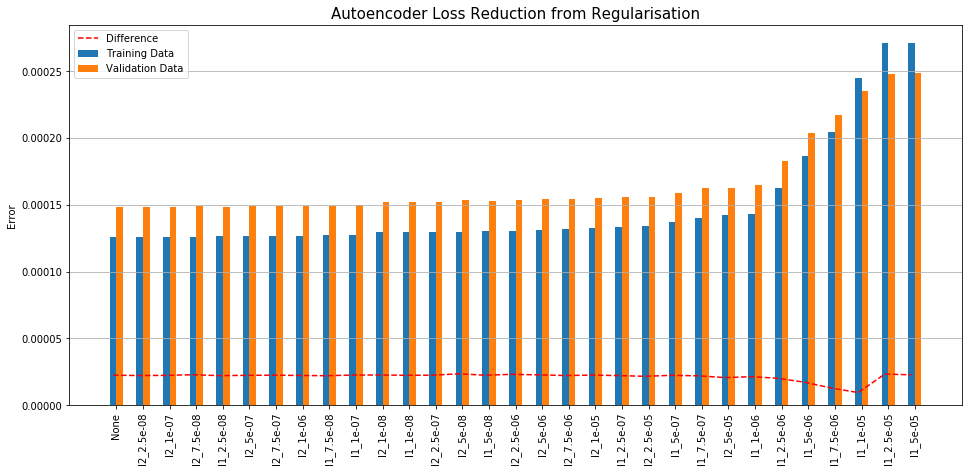

In [374]:
ind = np.arange(bias_variance_df.shape[0])
width = 0.25       

plt.figure(figsize = (16, 7))
plt.bar(ind, bias_variance_df['train_error'], width, label = 'Training Data')
plt.bar(ind + width, bias_variance_df['test_error'], width, label = 'Validation Data')
# plt.bar(ind + width * 2, bias_variance_df['difference'], width, label = 'Difference')
plt.plot(bias_variance_df['difference'], label = 'Difference', color = 'r', linestyle = '--')

plt.ylabel('Error')
plt.title('Autoencoder Loss Reduction from Regularisation', fontsize = 15)

plt.xticks(ind + width / 2, bias_variance_df.index, rotation = 90)
plt.legend(loc = 'best')
plt.grid(axis = 'y')
plt.show() 

In [375]:
lowest_bv_diff = bias_variance_df.sort_values('difference').index[0]
lowest_bv_train = bias_variance_df.sort_values('train_error').index[0]
lowest_bv_diff, lowest_bv_train

('l1_1e-05', 'None')

## Running T tests to test for differences between actual and reconstructed data

In [387]:
test_reconstructed_df = pd.DataFrame(
    model.predict(test_returns_df),
    columns = test_returns_df.columns, 
    index = test_returns_df.index
)

test_reconstructed_df.shape

(1304, 326)

In [404]:
evaluation_df = pd.DataFrame()

n_cos = reconstructed_df.shape[1]

for i in range(n_cos): 
    isin = reconstructed_df.columns[i]
    
    train_t_stat, train_p_val = stats.ttest_ind(train_returns_df[isin], reconstructed_df[isin])
    test_t_stat, test_p_val = stats.ttest_ind(test_returns_df[isin], test_reconstructed_df[isin])
    train_r2 = r2_score(train_returns_df[isin], reconstructed_df[isin])
    test_r2 = r2_score(test_returns_df[isin], test_reconstructed_df[isin])
    
    if train_p_val < 0.05:
        train_sig = True
    else:
        train_sig = False
        
    if test_p_val < 0.05:
        test_sig = True
    else:
        test_sig = False
    
    
    evaluation_df.loc[isin, 'name'] = map_df.loc[map_df['ISIN'] == isin, 'Company Common Name'].values[0]
    evaluation_df.loc[isin, 'train_t_stat'] = train_t_stat
    evaluation_df.loc[isin, 'train_p_val'] = train_p_val
    evaluation_df.loc[isin, 'train_sig_5%'] = train_sig
    evaluation_df.loc[isin, 'train_r2'] = train_r2
    evaluation_df.loc[isin, 'test_t_stat'] = test_t_stat
    evaluation_df.loc[isin, 'test_p_val'] = test_p_val
    evaluation_df.loc[isin, 'test_sig_5%'] = test_sig
    evaluation_df.loc[isin, 'test_r2'] = test_r2
    

train_sig = evaluation_df['train_sig_5%'].sum()
test_sig = evaluation_df['test_sig_5%'].sum()

train_sig, test_sig

(23, 40)

In [403]:
1 - (train_sig / n_cos), 1 - (test_sig / n_cos)

(0.9294478527607362, 0.8773006134969326)

In [399]:
evaluation_df['train_r2'].mean(), evaluation_df['test_r2'].mean()

(0.5281623585117058, 0.41046967871670503)

In [418]:
r2_df = pd.DataFrame()

r2_df.loc['Min', 'Train'] = evaluation_df['train_r2'].min()
r2_df.loc['Max', 'Train'] = evaluation_df['train_r2'].max()
r2_df.loc['Mean', 'Train'] = evaluation_df['train_r2'].mean()
r2_df.loc['Min', 'Test'] = evaluation_df['test_r2'].min()
r2_df.loc['Max', 'Test'] = evaluation_df['test_r2'].max()
r2_df.loc['Mean', 'Test'] = evaluation_df['test_r2'].mean()

r2_df.to_csv('../Data/ae_r2.csv')

r2_df

,Train,Test
Min,0.203585,0.101517
Max,0.780913,0.847078
Mean,0.528162,0.410470
